In [1]:
import os
import wx
app = wx.App()
backend = __import__("Integration")
t1 = backend.turtle_setup()
home = (0,0)

In [2]:
class TabOne(wx.Panel):
    def __init__(self, parent):
        wx.Panel.__init__(self, parent)
        
        img = wx.Image(500, 500)
        self.imageCtrl = wx.StaticBitmap(self, wx.ID_ANY, wx.Bitmap(img))
        
class TabTwo(wx.Panel):
    def __init__(self, parent):
        wx.Panel.__init__(self, parent)
        self.GCODE = wx.TextCtrl(self, style = wx.TE_READONLY | wx.TE_MULTILINE)
        
        bsizer = wx.BoxSizer()
        bsizer.Add(self.GCODE, 1, wx.EXPAND)
        
        self.SetSizerAndFit(bsizer)

In [3]:
class MainPanel(wx.Panel):
    def __init__(self, parent):
        wx.Panel.__init__(self, parent)
        
        subSizer = wx.BoxSizer(wx.VERTICAL)
        grid = wx.GridBagSizer(hgap=5, vgap=5)
        
        self.filepath = wx.TextCtrl(self, value="Filename", size=(500,-1), style = wx.TE_READONLY)

        self.btnOpen =wx.Button(self, label="Open")
        self.Bind(wx.EVT_BUTTON, self.OnOpen, self.btnOpen)
        
        self.btnCalibrate =wx.Button(self, label="Calibrate")
        self.Bind(wx.EVT_BUTTON, self.OnCalibrate, self.btnCalibrate)
        
        self.btnPrint =wx.Button(self, label="Print Image")
        self.Bind(wx.EVT_BUTTON, self.OnPrint, self.btnPrint)
        
        self.nb = wx.Notebook(self)
        
        self.tab1 = TabOne(self.nb)
        self.tab2 = TabTwo(self.nb)
        
        self.nb.AddPage(self.tab1, "Image Preview")
        self.nb.AddPage(self.tab2, "GCODE")
        
        grid.Add(self.btnOpen, pos=(0,0))
        grid.Add(self.btnCalibrate, pos=(0,1))
        grid.Add(self.btnPrint, pos=(0,2))
        grid.Add(self.filepath, pos=(1,0), span=(0,5))
        grid.Add(self.nb, pos=(2,0), span=(5,5))
        subSizer.Add(grid, 0, wx.ALL, 5)
        self.SetSizerAndFit(subSizer)
        
        self.calibrated = False
        
    def OnOpen(self,e):
        """ Open a file"""
        self.dirname = ''
        self.filename = ''
        self.file_extension = ''
        wildcard = "DXF files (*.dxf)|*.dxf|JPEG and PNG files (*.jpg;*.png)|*.jpg;*.png"
        dlg = wx.FileDialog(self, "Choose a file", self.dirname, "", wildcard, wx.FD_OPEN)
        if dlg.ShowModal() == wx.ID_OK:
            self.filename = dlg.GetFilename()
            self.dirname = dlg.GetDirectory()
            self.path = self.dirname + "\\" + self.filename
            self.filepath.SetValue(self.dirname + "\\" + self.filename)
            self.file_extension = os.path.splitext(self.path)[1]
            if self.file_extension.lower() == ".png" or self.file_extension.lower() == ".jpg":
                self.PreviewImage(self, self.path)
                backend.png_generate_gcode(self.path, 0.7, "output.gcode")
                generated = True
            elif self.file_extension.lower() == ".dxf":
                print(self.path)
                self.PreviewDXF(self, self.path)
                backend.dxf_generate_gcode(self.path, "output.gcode")
                generated = True
            else:
                print(self.file_extension)
            if generated == True:
                self.PreviewGCODE(self)
        dlg.Destroy()
        
    def PreviewImage(self, e, path):
        filename, file_extension = os.path.splitext(path)
        img_size = 500
        img = wx.Image(path, wx.BITMAP_TYPE_ANY)
        W = img.GetWidth()
        H = img.GetHeight()
        if W > H:
            NewW = img_size
            NewH = img_size * H / W
        else:
            NewH = img_size
            NewW = img_size * W / H
        img = img.Scale(NewW,NewH)
        self.tab1.imageCtrl.SetBitmap(wx.Bitmap(img))
        self.Refresh()
    
    def PreviewDXF(self, e, path):
        backend.view_dxf(path)
        img_size = 500
        img = wx.Image('Images/Outputs/dxf_output.png', wx.BITMAP_TYPE_ANY)
        W = img.GetWidth()
        H = img.GetHeight()
        if W > H:
            NewW = img_size
            NewH = img_size * H / W
        else:
            NewH = img_size
            NewW = img_size * W / H
        img = img.Scale(NewW,NewH)
        self.tab1.imageCtrl.SetBitmap(wx.Bitmap(img))
        self.Refresh()
        
    def PreviewGCODE(self, e):
        fileGCODE = open("output.gcode", 'r') 
        Lines = fileGCODE.readlines()
        string_lines = ""
        for line in Lines:
            string_lines = string_lines + line
        self.tab2.GCODE.WriteText(string_lines)
        
    def OnCalibrate(self, e):
        dlg = wx.MessageDialog(self, "Are you sure you want to calibrate the simulation home position?",'Calibrate?',wx.YES_NO | wx.ICON_QUESTION)
        result = dlg.ShowModal()
        if result == wx.ID_YES:
            frame = CalibrationWindow(None, "Calibrate")
            parent=wx.GetTopLevelParent(self)
            parent.Show(False)
            frame.SetFocus()
            frame.Raise()
        else:
            print("No pressed")
            
    def OnPrint(self, e):
        t1 = backend.open_sim("Click to close when simulation finishes.")
        backend.draw_output(t1, "output.gcode", 1)
        

In [4]:
class MainWindow(wx.Frame):

    def __init__(self, parent, title):
        self.dirname=''
        
        self.frame = wx.Frame.__init__(self, parent, title=title, size=(500,-1))
        self.CreateStatusBar()
        panel = MainPanel(self)
        
        filemenu= wx.Menu()
        menuOpen = filemenu.Append(wx.ID_OPEN, "&Open"," Open a file")
        menuAbout = filemenu.Append(wx.ID_ABOUT, "&About"," Information about this program")
        menuExit = filemenu.Append(wx.ID_EXIT,"E&xit"," Terminate the program")
        
        menuBar = wx.MenuBar()
        menuBar.Append(filemenu,"&File")
        self.SetMenuBar(menuBar)
        
        self.Bind(wx.EVT_MENU, self.OnOpen, menuOpen)
        self.Bind(wx.EVT_MENU, self.OnAbout, menuAbout)
        self.Bind(wx.EVT_MENU, self.OnExit, menuExit)
        
        mainSizer = wx.BoxSizer(wx.VERTICAL)
        mainSizer.Add(panel)
        self.SetSizerAndFit(mainSizer)
        self.Show(True)
    
    def OnOpen(self,e):
        self.dirname = ''
        self.filename = ''
        wildcard = "JPEG and PNG files (*.jpg;*.png)|*.jpg;*.png|DXF files (*.dxf)|*.dxf"
        dlg = wx.FileDialog(self, "Choose a file", self.dirname, "", wildcard, wx.FD_OPEN)
        if dlg.ShowModal() == wx.ID_OK:
            self.filename = dlg.GetFilename()
            self.dirname = dlg.GetDirectory()
            self.path = self.dirname + "\\" + self.filename
            self.filepath.SetValue(self.dirname + "\\" + self.filename)
            self.PreviewImage(self, self.path)
        dlg.Destroy()
        
    def OnAbout(self,e):
        dlg = wx.MessageDialog( self, "This program was created as an MSc dissertation. " +
                            "It can convert PNG, JPEG & DXF files into GCODE and then create a 2D print from the GCODE.")
        dlg.ShowModal()
        dlg.Destroy()

    def OnExit(self,e):
        self.Close(True)  # Close the frame.

In [5]:
class CalibrationPanel(wx.Panel):
    def __init__(self, parent):
        self.t1 = backend.open_sim("Calibrate")
        global home
        backend.move_turtle(self.t1, home[0], home[1], 1)
        
        wx.Panel.__init__(self, parent)

        subSizer = wx.BoxSizer(wx.VERTICAL)
        grid = wx.GridBagSizer(hgap=5, vgap=5)
        
        self.lblX = wx.StaticText(self, wx.ID_ANY, label="Home x value:", style=wx.ALIGN_CENTER)
        self.txtXCoord = wx.TextCtrl(self, value=str(home[0]), size=(100,-1))
        
        self.lblY = wx.StaticText(self, wx.ID_ANY, label="Home Y value:", style=wx.ALIGN_CENTER)
        self.txtYCoord = wx.TextCtrl(self, value=str(home[1]), size=(100,-1))
        
        self.btnCalibrate =wx.Button(self, label="Set home")
        self.Bind(wx.EVT_BUTTON, self.OnCalibrate, self.btnCalibrate)
        
        self.btnExit =wx.Button(self, label="Done")
        self.Bind(wx.EVT_BUTTON, self.OnExit, self.btnExit)
        
        grid.Add(self.lblX, pos=(0,0))
        grid.Add(self.txtXCoord, pos=(0,1))
        grid.Add(self.lblY, pos=(0,2))
        grid.Add(self.txtYCoord, pos=(0,3))
        grid.Add(self.btnCalibrate, pos=(1,1))
        grid.Add(self.btnExit, pos=(1,3))
        subSizer.Add(grid, 0, wx.ALL, 5)
        self.SetSizerAndFit(subSizer)
        
        
    def OnCalibrate(self,e):
        xCoord = int(self.txtXCoord.GetValue())
        yCoord = int(self.txtYCoord.GetValue())
        backend.calibrate_sim(self.t1, xCoord, yCoord)
        global home
        home = (xCoord,yCoord)
        
    def OnExit(self,e):
        dlg = wx.MessageDialog(self, "Any changes since confirming calibration by pressing 'Set Home' will be lost. \n" + 
                               "Are you sure you're done calibrating the simulation home position?",
                               'Calibrated?',wx.YES_NO | wx.ICON_QUESTION)
        result = dlg.ShowModal()
        if result == wx.ID_YES:
            backend.close_sim(self.t1)
            mainFrame.Show(True)
            parent=wx.GetTopLevelParent(self)
            parent.Close(True)  # Close the frame.
        else:
            print("No pressed")

In [6]:
class CalibrationWindow(wx.Frame):

    def __init__(self, parent, title):
        self.dirname=''
        
        self.frame = wx.Frame.__init__(self, parent, title=title, size=(500,-1), style=wx.CAPTION)
        self.CreateStatusBar()
        panel = CalibrationPanel(self)
        
        mainSizer = wx.BoxSizer(wx.VERTICAL)
        mainSizer.Add(panel)
        self.SetSizerAndFit(mainSizer)
        self.Show(True)

G00 X144 Y40 ; 
144.0
40.0
G00
----------------------------------------
G01 X144 Y45 ; 
144.0
45.0
G01
----------------------------------------
G00 X144 Y45 ; 
144.0
45.0
G00
----------------------------------------
G01 X144 Y50 ; 
144.0
50.0
G01
----------------------------------------
G00 X144 Y50 ; 
144.0
50.0
G00
----------------------------------------
G01 X144 Y55 ; 
144.0
55.0
G01
----------------------------------------
G00 X116 Y60 ; 
116.0
60.0
G00
----------------------------------------
G01 X116 Y65 ; 
116.0
65.0
G01
----------------------------------------
G00 X144 Y60 ; 
144.0
60.0
G00
----------------------------------------
G01 X144 Y65 ; 
144.0
65.0
G01
----------------------------------------
G00 X144 Y65 ; 
144.0
65.0
G00
----------------------------------------
G01 X144 Y70 ; 
144.0
70.0
G01
----------------------------------------
G00 X116 Y70 ; 
116.0
70.0
G00
----------------------------------------
G01 X116 Y75 ; 
116.0
75.0
G01
---------------------------------

----------------------------------------
G01 X205 Y47 ; 
205.0
47.0
G01
----------------------------------------
G00 X205 Y47 ; 
205.0
47.0
G00
----------------------------------------
G01 X210 Y47 ; 
210.0
47.0
G01
----------------------------------------
G00 X210 Y47 ; 
210.0
47.0
G00
----------------------------------------
G01 X215 Y46 ; 
215.0
46.0
G01
----------------------------------------
G00 X215 Y46 ; 
215.0
46.0
G00
----------------------------------------
G01 X219 Y50 ; 
219.0
50.0
G01
----------------------------------------
G00 X136 Y55 ; 
136.0
55.0
G00
----------------------------------------
G01 X140 Y50 ; 
140.0
50.0
G01
----------------------------------------
G00 X140 Y50 ; 
140.0
50.0
G00
----------------------------------------
G01 X140 Y50 ; 
140.0
50.0
G01
----------------------------------------
G00 X169 Y50 ; 
169.0
50.0
G00
----------------------------------------
G01 X169 Y55 ; 
169.0
55.0
G01
----------------------------------------
G00 X176 Y50 ; 
176.0
5

----------------------------------------
G00 X170 Y77 ; 
170.0
77.0
G00
----------------------------------------
G01 X173 Y80 ; 
173.0
80.0
G01
----------------------------------------
G00 X191 Y75 ; 
191.0
75.0
G00
----------------------------------------
G01 X195 Y79 ; 
195.0
79.0
G01
----------------------------------------
G00 X195 Y79 ; 
195.0
79.0
G00
----------------------------------------
G01 X200 Y79 ; 
200.0
79.0
G01
----------------------------------------
G00 X200 Y79 ; 
200.0
79.0
G00
----------------------------------------
G01 X205 Y79 ; 
205.0
79.0
G01
----------------------------------------
G00 X205 Y79 ; 
205.0
79.0
G00
----------------------------------------
G01 X210 Y79 ; 
210.0
79.0
G01
----------------------------------------
G00 X210 Y79 ; 
210.0
79.0
G00
----------------------------------------
G01 X215 Y79 ; 
215.0
79.0
G01
----------------------------------------
G00 X215 Y79 ; 
215.0
79.0
G00
----------------------------------------
G01 X220 Y79 ; 
220.0
7

----------------------------------------
G00 X10 Y104 ; 
10.0
104.0
G00
----------------------------------------
G01 X15 Y104 ; 
15.0
104.0
G01
----------------------------------------
G00 X15 Y104 ; 
15.0
104.0
G00
----------------------------------------
G01 X16 Y105 ; 
16.0
105.0
G01
----------------------------------------
G00 X123 Y100 ; 
123.0
100.0
G00
----------------------------------------
G01 X125 Y101 ; 
125.0
101.0
G01
----------------------------------------
G00 X125 Y101 ; 
125.0
101.0
G00
----------------------------------------
G01 X130 Y102 ; 
130.0
102.0
G01
----------------------------------------
G00 X130 Y102 ; 
130.0
102.0
G00
----------------------------------------
G01 X134 Y105 ; 
134.0
105.0
G01
----------------------------------------
G00 X142 Y100 ; 
142.0
100.0
G00
----------------------------------------
G01 X145 Y103 ; 
145.0
103.0
G01
----------------------------------------
G00 X145 Y103 ; 
145.0
103.0
G00
----------------------------------------
G01 X

----------------------------------------
G00 X49 Y165 ; 
49.0
165.0
G00
----------------------------------------
G01 X49 Y170 ; 
49.0
170.0
G01
----------------------------------------
G00 X52 Y165 ; 
52.0
165.0
G00
----------------------------------------
G01 X54 Y170 ; 
54.0
170.0
G01
----------------------------------------
G00 X84 Y165 ; 
84.0
165.0
G00
----------------------------------------
G01 X84 Y170 ; 
84.0
170.0
G01
----------------------------------------
G00 X116 Y165 ; 
116.0
165.0
G00
----------------------------------------
G01 X116 Y170 ; 
116.0
170.0
G01
----------------------------------------
G00 X144 Y165 ; 
144.0
165.0
G00
----------------------------------------
G01 X144 Y170 ; 
144.0
170.0
G01
----------------------------------------
G00 X22 Y170 ; 
22.0
170.0
G00
----------------------------------------
G01 X22 Y175 ; 
22.0
175.0
G01
----------------------------------------
G00 X49 Y170 ; 
49.0
170.0
G00
----------------------------------------
G01 X49 Y175 ; 

----------------------------------------
G00 X125 Y200 ; 
125.0
200.0
G00
----------------------------------------
G01 X125 Y200 ; 
125.0
200.0
G01
----------------------------------------
G00 X125 Y200 ; 
125.0
200.0
G00
----------------------------------------
G01 X130 Y204 ; 
130.0
204.0
G01
----------------------------------------
G00 X130 Y204 ; 
130.0
204.0
G00
----------------------------------------
G01 X135 Y203 ; 
135.0
203.0
G01
----------------------------------------
G00 X138 Y200 ; 
138.0
200.0
G00
----------------------------------------
G01 X135 Y203 ; 
135.0
203.0
G01
----------------------------------------


AttributeError: '_Screen' object has no attribute '_mode'

G00 X26 Y25 ; 
26.0
25.0
G00
----------------------------------------
G01 X30 Y22 ; 
30.0
22.0
G01
----------------------------------------
G00 X30 Y22 ; 
30.0
22.0
G00
----------------------------------------
G01 X35 Y22 ; 
35.0
22.0
G01
----------------------------------------
G00 X35 Y22 ; 
35.0
22.0
G00
----------------------------------------
G01 X40 Y22 ; 
40.0
22.0
G01
----------------------------------------
G00 X40 Y22 ; 
40.0
22.0
G00
----------------------------------------
G01 X43 Y25 ; 
43.0
25.0
G01
----------------------------------------
G00 X72 Y25 ; 
72.0
25.0
G00
----------------------------------------
G01 X75 Y22 ; 
75.0
22.0
G01
----------------------------------------
G00 X75 Y22 ; 
75.0
22.0
G00
----------------------------------------
G01 X80 Y22 ; 
80.0
22.0
G01
----------------------------------------
G00 X80 Y22 ; 
80.0
22.0
G00
----------------------------------------
G01 X85 Y21 ; 
85.0
21.0
G01
----------------------------------------
G00 X85 Y21 ; 
85.0


----------------------------------------
G00 X84 Y55 ; 
84.0
55.0
G00
----------------------------------------
G01 X83 Y60 ; 
83.0
60.0
G01
----------------------------------------
G00 X116 Y55 ; 
116.0
55.0
G00
----------------------------------------
G01 X116 Y60 ; 
116.0
60.0
G01
----------------------------------------
G00 X144 Y55 ; 
144.0
55.0
G00
----------------------------------------
G01 X144 Y60 ; 
144.0
60.0
G01
----------------------------------------
G00 X22 Y60 ; 
22.0
60.0
G00
----------------------------------------
G01 X22 Y65 ; 
22.0
65.0
G01
----------------------------------------
G00 X49 Y60 ; 
49.0
60.0
G00
----------------------------------------
G01 X50 Y62 ; 
50.0
62.0
G01
----------------------------------------
G00 X52 Y60 ; 
52.0
60.0
G00
----------------------------------------
G01 X50 Y62 ; 
50.0
62.0
G01
----------------------------------------
G00 X79 Y65 ; 
79.0
65.0
G00
----------------------------------------
G01 X80 Y63 ; 
80.0
63.0
G01
------------

----------------------------------------
G00 X142 Y125 ; 
142.0
125.0
G00
----------------------------------------
G01 X145 Y122 ; 
145.0
122.0
G01
----------------------------------------
G00 X145 Y122 ; 
145.0
122.0
G00
----------------------------------------
G01 X150 Y121 ; 
150.0
121.0
G01
----------------------------------------
G00 X150 Y121 ; 
150.0
121.0
G00
----------------------------------------
G01 X155 Y122 ; 
155.0
122.0
G01
----------------------------------------
G00 X155 Y122 ; 
155.0
122.0
G00
----------------------------------------
G01 X159 Y125 ; 
159.0
125.0
G01
----------------------------------------
G00 X1 Y130 ; 
1.0
130.0
G00
----------------------------------------
G01 X5 Y126 ; 
5.0
126.0
G01
----------------------------------------
G00 X6 Y125 ; 
6.0
125.0
G00
----------------------------------------
G01 X5 Y126 ; 
5.0
126.0
G01
----------------------------------------
G00 X109 Y130 ; 
109.0
130.0
G00
----------------------------------------
G01 X110 Y129

----------------------------------------
G01 X205 Y142 ; 
205.0
142.0
G01
----------------------------------------
G00 X205 Y142 ; 
205.0
142.0
G00
----------------------------------------
G01 X210 Y142 ; 
210.0
142.0
G01
----------------------------------------
G00 X210 Y142 ; 
210.0
142.0
G00
----------------------------------------
G01 X215 Y142 ; 
215.0
142.0
G01
----------------------------------------
G00 X215 Y142 ; 
215.0
142.0
G00
----------------------------------------
G01 X220 Y142 ; 
220.0
142.0
G01
----------------------------------------
G00 X220 Y142 ; 
220.0
142.0
G00
----------------------------------------
G01 X224 Y142 ; 
224.0
142.0
G01
----------------------------------------
G00 X112 Y145 ; 
112.0
145.0
G00
----------------------------------------
G01 X115 Y150 ; 
115.0
150.0
G01
----------------------------------------
G00 X115 Y150 ; 
115.0
150.0
G00
----------------------------------------
G01 X115 Y150 ; 
115.0
150.0
G01
--------------------------------------

----------------------------------------
G00 X180 Y172 ; 
180.0
172.0
G00
----------------------------------------
G01 X184 Y175 ; 
184.0
175.0
G01
----------------------------------------
G00 X196 Y170 ; 
196.0
170.0
G00
----------------------------------------
G01 X200 Y173 ; 
200.0
173.0
G01
----------------------------------------
G00 X200 Y173 ; 
200.0
173.0
G00
----------------------------------------
G01 X205 Y174 ; 
205.0
174.0
G01
----------------------------------------
G00 X210 Y170 ; 
210.0
170.0
G00
----------------------------------------
G01 X205 Y174 ; 
205.0
174.0
G01
----------------------------------------
G00 X206 Y175 ; 
206.0
175.0
G00
----------------------------------------
G01 X210 Y170 ; 
210.0
170.0
G01
----------------------------------------
G00 X210 Y170 ; 
210.0
170.0
G00
----------------------------------------
G01 X215 Y172 ; 
215.0
172.0
G01
----------------------------------------
G00 X215 Y172 ; 
215.0
172.0
G00
--------------------------------------

----------------------------------------
G00 X151 Y135 ; 
151.0
135.0
G00
----------------------------------------
G01 X150 Y136 ; 
150.0
136.0
G01
----------------------------------------
G00 X154 Y140 ; 
154.0
140.0
G00
----------------------------------------
G01 X155 Y139 ; 
155.0
139.0
G01
----------------------------------------
G00 X155 Y139 ; 
155.0
139.0
G00
----------------------------------------
G01 X160 Y138 ; 
160.0
138.0
G01
----------------------------------------
G00 X160 Y138 ; 
160.0
138.0
G00
----------------------------------------
G01 X165 Y138 ; 
165.0
138.0
G01
----------------------------------------
G00 X169 Y135 ; 
169.0
135.0
G00
----------------------------------------
G01 X165 Y138 ; 
165.0
138.0
G01
----------------------------------------
G00 X188 Y135 ; 
188.0
135.0
G00
----------------------------------------
G01 X190 Y137 ; 
190.0
137.0
G01
----------------------------------------
G00 X190 Y137 ; 
190.0
137.0
G00
--------------------------------------

----------------------------------------
G01 X235 Y171 ; 
235.0
171.0
G01
----------------------------------------
G00 X236 Y170 ; 
236.0
170.0
G00
----------------------------------------
G01 X235 Y171 ; 
235.0
171.0
G01
----------------------------------------
G00 X148 Y205 ; 
148.0
205.0
G00
----------------------------------------
G01 X150 Y203 ; 
150.0
203.0
G01
----------------------------------------
G00 X150 Y203 ; 
150.0
203.0
G00
----------------------------------------
G01 X155 Y202 ; 
155.0
202.0
G01
----------------------------------------
G00 X155 Y202 ; 
155.0
202.0
G00
----------------------------------------
G01 X158 Y205 ; 
158.0
205.0
G01
----------------------------------------
G00 X202 Y205 ; 
202.0
205.0
G00
----------------------------------------
G01 X205 Y202 ; 
205.0
202.0
G01
----------------------------------------
G00 X205 Y202 ; 
205.0
202.0
G00
----------------------------------------
G01 X208 Y205 ; 
208.0
205.0
G01
--------------------------------------

AttributeError: '_Screen' object has no attribute '_mode'

G00 X564 Y10 ; 
564.0
10.0
G00
----------------------------------------
G01 X565 Y9 ; 
565.0
9.0
G01
----------------------------------------
G00 X565 Y9 ; 
565.0
9.0
G00
----------------------------------------
G01 X566 Y10 ; 
566.0
10.0
G01
----------------------------------------
G00 X564 Y10 ; 
564.0
10.0
G00
----------------------------------------
G01 X564 Y15 ; 
564.0
15.0
G01
----------------------------------------
G00 X566 Y10 ; 
566.0
10.0
G00
----------------------------------------
G01 X570 Y14 ; 
570.0
14.0
G01
----------------------------------------
G00 X570 Y14 ; 
570.0
14.0
G00
----------------------------------------
G01 X571 Y15 ; 
571.0
15.0
G01
----------------------------------------
G00 X564 Y15 ; 
564.0
15.0
G00
----------------------------------------
G01 X565 Y16 ; 
565.0
16.0
G01
----------------------------------------
G00 X565 Y16 ; 
565.0
16.0
G00
----------------------------------------
G01 X569 Y20 ; 
569.0
20.0
G01
-------------------------------------

----------------------------------------
G00 X616 Y95 ; 
616.0
95.0
G00
----------------------------------------
G01 X620 Y99 ; 
620.0
99.0
G01
----------------------------------------
G00 X620 Y99 ; 
620.0
99.0
G00
----------------------------------------
G01 X621 Y100 ; 
621.0
100.0
G01
----------------------------------------
G00 X614 Y100 ; 
614.0
100.0
G00
----------------------------------------
G01 X615 Y101 ; 
615.0
101.0
G01
----------------------------------------
G00 X615 Y101 ; 
615.0
101.0
G00
----------------------------------------
G01 X619 Y105 ; 
619.0
105.0
G01
----------------------------------------
G00 X621 Y100 ; 
621.0
100.0
G00
----------------------------------------
G01 X621 Y105 ; 
621.0
105.0
G01
----------------------------------------
G00 X619 Y105 ; 
619.0
105.0
G00
----------------------------------------
G01 X619 Y110 ; 
619.0
110.0
G01
----------------------------------------
G00 X621 Y105 ; 
621.0
105.0
G00
----------------------------------------
G01

----------------------------------------
G01 X295 Y166 ; 
295.0
166.0
G01
----------------------------------------
G00 X295 Y166 ; 
295.0
166.0
G00
----------------------------------------
G01 X299 Y170 ; 
299.0
170.0
G01
----------------------------------------
G00 X301 Y165 ; 
301.0
165.0
G00
----------------------------------------
G01 X301 Y170 ; 
301.0
170.0
G01
----------------------------------------
G00 X594 Y165 ; 
594.0
165.0
G00
----------------------------------------
G01 X595 Y167 ; 
595.0
167.0
G01
----------------------------------------
G00 X596 Y165 ; 
596.0
165.0
G00
----------------------------------------
G01 X595 Y167 ; 
595.0
167.0
G01
----------------------------------------
G00 X598 Y170 ; 
598.0
170.0
G00
----------------------------------------
G01 X600 Y169 ; 
600.0
169.0
G01
----------------------------------------
G00 X600 Y169 ; 
600.0
169.0
G00
----------------------------------------
G01 X601 Y170 ; 
601.0
170.0
G01
--------------------------------------

----------------------------------------
G01 X611 Y190 ; 
611.0
190.0
G01
----------------------------------------
G00 X664 Y185 ; 
664.0
185.0
G00
----------------------------------------
G01 X665 Y186 ; 
665.0
186.0
G01
----------------------------------------
G00 X665 Y186 ; 
665.0
186.0
G00
----------------------------------------
G01 X669 Y190 ; 
669.0
190.0
G01
----------------------------------------
G00 X671 Y185 ; 
671.0
185.0
G00
----------------------------------------
G01 X671 Y190 ; 
671.0
190.0
G01
----------------------------------------
G00 X288 Y190 ; 
288.0
190.0
G00
----------------------------------------
G01 X290 Y192 ; 
290.0
192.0
G01
----------------------------------------
G00 X290 Y192 ; 
290.0
192.0
G00
----------------------------------------
G01 X293 Y195 ; 
293.0
195.0
G01
----------------------------------------
G00 X297 Y190 ; 
297.0
190.0
G00
----------------------------------------
G01 X298 Y195 ; 
298.0
195.0
G01
--------------------------------------

----------------------------------------
G00 X680 Y203 ; 
680.0
203.0
G00
----------------------------------------
G01 X681 Y205 ; 
681.0
205.0
G01
----------------------------------------
G00 X298 Y205 ; 
298.0
205.0
G00
----------------------------------------
G01 X300 Y207 ; 
300.0
207.0
G01
----------------------------------------
G00 X300 Y207 ; 
300.0
207.0
G00
----------------------------------------
G01 X303 Y210 ; 
303.0
210.0
G01
----------------------------------------
G00 X307 Y205 ; 
307.0
205.0
G00
----------------------------------------
G01 X307 Y210 ; 
307.0
210.0
G01
----------------------------------------
G00 X319 Y205 ; 
319.0
205.0
G00
----------------------------------------
G01 X320 Y206 ; 
320.0
206.0
G01
----------------------------------------
G00 X325 Y205 ; 
325.0
205.0
G00
----------------------------------------
G01 X320 Y206 ; 
320.0
206.0
G01
----------------------------------------
G00 X324 Y210 ; 
324.0
210.0
G00
--------------------------------------

----------------------------------------
G01 X240 Y213 ; 
240.0
213.0
G01
----------------------------------------
G00 X240 Y213 ; 
240.0
213.0
G00
----------------------------------------
G01 X245 Y213 ; 
245.0
213.0
G01
----------------------------------------
G00 X245 Y213 ; 
245.0
213.0
G00
----------------------------------------
G01 X250 Y213 ; 
250.0
213.0
G01
----------------------------------------
G00 X250 Y213 ; 
250.0
213.0
G00
----------------------------------------
G01 X255 Y213 ; 
255.0
213.0
G01
----------------------------------------
G00 X255 Y213 ; 
255.0
213.0
G00
----------------------------------------
G01 X260 Y213 ; 
260.0
213.0
G01
----------------------------------------
G00 X260 Y213 ; 
260.0
213.0
G00
----------------------------------------
G01 X265 Y213 ; 
265.0
213.0
G01
----------------------------------------
G00 X265 Y213 ; 
265.0
213.0
G00
----------------------------------------
G01 X270 Y213 ; 
270.0
213.0
G01
--------------------------------------

----------------------------------------
G00 X525 Y214 ; 
525.0
214.0
G00
----------------------------------------
G01 X530 Y214 ; 
530.0
214.0
G01
----------------------------------------
G00 X530 Y214 ; 
530.0
214.0
G00
----------------------------------------
G01 X535 Y214 ; 
535.0
214.0
G01
----------------------------------------
G00 X535 Y214 ; 
535.0
214.0
G00
----------------------------------------
G01 X540 Y214 ; 
540.0
214.0
G01
----------------------------------------
G00 X540 Y214 ; 
540.0
214.0
G00
----------------------------------------
G01 X545 Y214 ; 
545.0
214.0
G01
----------------------------------------
G00 X545 Y214 ; 
545.0
214.0
G00
----------------------------------------
G01 X550 Y214 ; 
550.0
214.0
G01
----------------------------------------
G00 X550 Y214 ; 
550.0
214.0
G00
----------------------------------------
G01 X551 Y215 ; 
551.0
215.0
G01
----------------------------------------
G00 X559 Y210 ; 
559.0
210.0
G00
--------------------------------------

----------------------------------------
G01 X317 Y230 ; 
317.0
230.0
G01
----------------------------------------
G00 X329 Y225 ; 
329.0
225.0
G00
----------------------------------------
G01 X329 Y230 ; 
329.0
230.0
G01
----------------------------------------
G00 X551 Y225 ; 
551.0
225.0
G00
----------------------------------------
G01 X551 Y230 ; 
551.0
230.0
G01
----------------------------------------
G00 X564 Y225 ; 
564.0
225.0
G00
----------------------------------------
G01 X564 Y230 ; 
564.0
230.0
G01
----------------------------------------
G00 X731 Y225 ; 
731.0
225.0
G00
----------------------------------------
G01 X731 Y230 ; 
731.0
230.0
G01
----------------------------------------
G00 X58 Y230 ; 
58.0
230.0
G00
----------------------------------------
G01 X58 Y235 ; 
58.0
235.0
G01
----------------------------------------
G00 X317 Y230 ; 
317.0
230.0
G00
----------------------------------------
G01 X317 Y235 ; 
317.0
235.0
G01
----------------------------------------
G

----------------------------------------
G00 X285 Y242 ; 
285.0
242.0
G00
----------------------------------------
G01 X290 Y242 ; 
290.0
242.0
G01
----------------------------------------
G00 X290 Y242 ; 
290.0
242.0
G00
----------------------------------------
G01 X295 Y242 ; 
295.0
242.0
G01
----------------------------------------
G00 X295 Y242 ; 
295.0
242.0
G00
----------------------------------------
G01 X300 Y242 ; 
300.0
242.0
G01
----------------------------------------
G00 X300 Y242 ; 
300.0
242.0
G00
----------------------------------------
G01 X305 Y242 ; 
305.0
242.0
G01
----------------------------------------
G00 X305 Y242 ; 
305.0
242.0
G00
----------------------------------------
G01 X310 Y242 ; 
310.0
242.0
G01
----------------------------------------
G00 X310 Y242 ; 
310.0
242.0
G00
----------------------------------------
G01 X315 Y242 ; 
315.0
242.0
G01
----------------------------------------
G00 X317 Y240 ; 
317.0
240.0
G00
--------------------------------------

----------------------------------------
G01 X585 Y241 ; 
585.0
241.0
G01
----------------------------------------
G00 X585 Y241 ; 
585.0
241.0
G00
----------------------------------------
G01 X590 Y241 ; 
590.0
241.0
G01
----------------------------------------
G00 X590 Y241 ; 
590.0
241.0
G00
----------------------------------------
G01 X595 Y241 ; 
595.0
241.0
G01
----------------------------------------
G00 X595 Y241 ; 
595.0
241.0
G00
----------------------------------------
G01 X600 Y241 ; 
600.0
241.0
G01
----------------------------------------
G00 X600 Y241 ; 
600.0
241.0
G00
----------------------------------------
G01 X605 Y241 ; 
605.0
241.0
G01
----------------------------------------
G00 X605 Y241 ; 
605.0
241.0
G00
----------------------------------------
G01 X610 Y241 ; 
610.0
241.0
G01
----------------------------------------
G00 X610 Y241 ; 
610.0
241.0
G00
----------------------------------------
G01 X615 Y241 ; 
615.0
241.0
G01
--------------------------------------

----------------------------------------
G01 X58 Y265 ; 
58.0
265.0
G01
----------------------------------------
G00 X88 Y260 ; 
88.0
260.0
G00
----------------------------------------
G01 X88 Y265 ; 
88.0
265.0
G01
----------------------------------------
G00 X649 Y260 ; 
649.0
260.0
G00
----------------------------------------
G01 X650 Y261 ; 
650.0
261.0
G01
----------------------------------------
G00 X650 Y261 ; 
650.0
261.0
G00
----------------------------------------
G01 X654 Y265 ; 
654.0
265.0
G01
----------------------------------------
G00 X656 Y260 ; 
656.0
260.0
G00
----------------------------------------
G01 X656 Y265 ; 
656.0
265.0
G01
----------------------------------------
G00 X679 Y260 ; 
679.0
260.0
G00
----------------------------------------
G01 X679 Y265 ; 
679.0
265.0
G01
----------------------------------------
G00 X681 Y260 ; 
681.0
260.0
G00
----------------------------------------
G01 X685 Y264 ; 
685.0
264.0
G01
----------------------------------------
G00

----------------------------------------
G01 X88 Y295 ; 
88.0
295.0
G01
----------------------------------------
G00 X694 Y290 ; 
694.0
290.0
G00
----------------------------------------
G01 X695 Y291 ; 
695.0
291.0
G01
----------------------------------------
G00 X695 Y291 ; 
695.0
291.0
G00
----------------------------------------
G01 X699 Y295 ; 
699.0
295.0
G01
----------------------------------------
G00 X731 Y290 ; 
731.0
290.0
G00
----------------------------------------
G01 X735 Y294 ; 
735.0
294.0
G01
----------------------------------------
G00 X735 Y294 ; 
735.0
294.0
G00
----------------------------------------
G01 X736 Y295 ; 
736.0
295.0
G01
----------------------------------------
G00 X18 Y295 ; 
18.0
295.0
G00
----------------------------------------
G01 X20 Y297 ; 
20.0
297.0
G01
----------------------------------------
G00 X20 Y297 ; 
20.0
297.0
G00
----------------------------------------
G01 X23 Y300 ; 
23.0
300.0
G01
----------------------------------------
G00 X27

----------------------------------------
G01 X88 Y330 ; 
88.0
330.0
G01
----------------------------------------
G00 X699 Y325 ; 
699.0
325.0
G00
----------------------------------------
G01 X699 Y330 ; 
699.0
330.0
G01
----------------------------------------
G00 X731 Y325 ; 
731.0
325.0
G00
----------------------------------------
G01 X731 Y330 ; 
731.0
330.0
G01
----------------------------------------
G00 X38 Y330 ; 
38.0
330.0
G00
----------------------------------------
G01 X40 Y332 ; 
40.0
332.0
G01
----------------------------------------
G00 X40 Y332 ; 
40.0
332.0
G00
----------------------------------------
G01 X43 Y335 ; 
43.0
335.0
G01
----------------------------------------
G00 X47 Y330 ; 
47.0
330.0
G00
----------------------------------------
G01 X48 Y335 ; 
48.0
335.0
G01
----------------------------------------
G00 X58 Y330 ; 
58.0
330.0
G00
----------------------------------------
G01 X58 Y335 ; 
58.0
335.0
G01
----------------------------------------
G00 X88 Y330 ; 

----------------------------------------
G01 X88 Y375 ; 
88.0
375.0
G01
----------------------------------------
G00 X699 Y370 ; 
699.0
370.0
G00
----------------------------------------
G01 X699 Y375 ; 
699.0
375.0
G01
----------------------------------------
G00 X731 Y370 ; 
731.0
370.0
G00
----------------------------------------
G01 X731 Y375 ; 
731.0
375.0
G01
----------------------------------------
G00 X31 Y375 ; 
31.0
375.0
G00
----------------------------------------
G01 X33 Y380 ; 
33.0
380.0
G01
----------------------------------------
G00 X37 Y375 ; 
37.0
375.0
G00
----------------------------------------
G01 X40 Y378 ; 
40.0
378.0
G01
----------------------------------------
G00 X40 Y378 ; 
40.0
378.0
G00
----------------------------------------
G01 X42 Y380 ; 
42.0
380.0
G01
----------------------------------------
G00 X58 Y375 ; 
58.0
375.0
G00
----------------------------------------
G01 X60 Y377 ; 
60.0
377.0
G01
----------------------------------------
G00 X60 Y377 ; 

----------------------------------------
G01 X699 Y420 ; 
699.0
420.0
G01
----------------------------------------
G00 X731 Y415 ; 
731.0
415.0
G00
----------------------------------------
G01 X731 Y420 ; 
731.0
420.0
G01
----------------------------------------
G00 X58 Y420 ; 
58.0
420.0
G00
----------------------------------------
G01 X58 Y425 ; 
58.0
425.0
G01
----------------------------------------
G00 X88 Y420 ; 
88.0
420.0
G00
----------------------------------------
G01 X88 Y425 ; 
88.0
425.0
G01
----------------------------------------
G00 X699 Y420 ; 
699.0
420.0
G00
----------------------------------------
G01 X700 Y421 ; 
700.0
421.0
G01
----------------------------------------
G00 X700 Y421 ; 
700.0
421.0
G00
----------------------------------------
G01 X705 Y421 ; 
705.0
421.0
G01
----------------------------------------
G00 X705 Y421 ; 
705.0
421.0
G00
----------------------------------------
G01 X710 Y421 ; 
710.0
421.0
G01
----------------------------------------
G00 X

----------------------------------------
G00 X92 Y480 ; 
92.0
480.0
G00
----------------------------------------
G01 X95 Y483 ; 
95.0
483.0
G01
----------------------------------------
G00 X98 Y480 ; 
98.0
480.0
G00
----------------------------------------
G01 X95 Y483 ; 
95.0
483.0
G01
----------------------------------------
G00 X97 Y485 ; 
97.0
485.0
G00
----------------------------------------
G01 X100 Y482 ; 
100.0
482.0
G01
----------------------------------------
G00 X100 Y482 ; 
100.0
482.0
G00
----------------------------------------
G01 X102 Y485 ; 
102.0
485.0
G01
----------------------------------------
G00 X699 Y480 ; 
699.0
480.0
G00
----------------------------------------
G01 X699 Y485 ; 
699.0
485.0
G01
----------------------------------------
G00 X736 Y480 ; 
736.0
480.0
G00
----------------------------------------
G01 X736 Y485 ; 
736.0
485.0
G01
----------------------------------------
G00 X0 Y488 ; 
0.0
488.0
G00
----------------------------------------
G01 X2 Y490

----------------------------------------
G01 X55 Y502 ; 
55.0
502.0
G01
----------------------------------------
G00 X55 Y502 ; 
55.0
502.0
G00
----------------------------------------
G01 X58 Y505 ; 
58.0
505.0
G01
----------------------------------------
G00 X88 Y500 ; 
88.0
500.0
G00
----------------------------------------
G01 X90 Y502 ; 
90.0
502.0
G01
----------------------------------------
G00 X90 Y502 ; 
90.0
502.0
G00
----------------------------------------
G01 X92 Y505 ; 
92.0
505.0
G01
----------------------------------------
G00 X103 Y500 ; 
103.0
500.0
G00
----------------------------------------
G01 X105 Y502 ; 
105.0
502.0
G01
----------------------------------------
G00 X105 Y502 ; 
105.0
502.0
G00
----------------------------------------
G01 X108 Y505 ; 
108.0
505.0
G01
----------------------------------------
G00 X112 Y500 ; 
112.0
500.0
G00
----------------------------------------
G01 X112 Y505 ; 
112.0
505.0
G01
----------------------------------------
G00 X133 Y5

----------------------------------------
G01 X699 Y520 ; 
699.0
520.0
G01
----------------------------------------
G00 X731 Y515 ; 
731.0
515.0
G00
----------------------------------------
G01 X731 Y520 ; 
731.0
520.0
G01
----------------------------------------
G00 X18 Y525 ; 
18.0
525.0
G00
----------------------------------------
G01 X20 Y522 ; 
20.0
522.0
G01
----------------------------------------
G00 X20 Y522 ; 
20.0
522.0
G00
----------------------------------------
G01 X22 Y525 ; 
22.0
525.0
G01
----------------------------------------
G00 X58 Y520 ; 
58.0
520.0
G00
----------------------------------------
G01 X58 Y525 ; 
58.0
525.0
G01
----------------------------------------
G00 X88 Y520 ; 
88.0
520.0
G00
----------------------------------------
G01 X88 Y525 ; 
88.0
525.0
G01
----------------------------------------
G00 X92 Y520 ; 
92.0
520.0
G00
----------------------------------------
G01 X95 Y522 ; 
95.0
522.0
G01
----------------------------------------
G00 X99 Y520 ; 
9

----------------------------------------
G00 X110 Y538 ; 
110.0
538.0
G00
----------------------------------------
G01 X112 Y540 ; 
112.0
540.0
G01
----------------------------------------
G00 X125 Y535 ; 
125.0
535.0
G00
----------------------------------------
G01 X128 Y540 ; 
128.0
540.0
G01
----------------------------------------
G00 X132 Y535 ; 
132.0
535.0
G00
----------------------------------------
G01 X135 Y540 ; 
135.0
540.0
G01
----------------------------------------
G00 X153 Y535 ; 
153.0
535.0
G00
----------------------------------------
G01 X155 Y540 ; 
155.0
540.0
G01
----------------------------------------
G00 X157 Y535 ; 
157.0
535.0
G00
----------------------------------------
G01 X155 Y540 ; 
155.0
540.0
G01
----------------------------------------
G00 X155 Y540 ; 
155.0
540.0
G00
----------------------------------------
G01 X160 Y538 ; 
160.0
538.0
G01
----------------------------------------
G00 X160 Y538 ; 
160.0
538.0
G00
--------------------------------------

----------------------------------------
G00 X699 Y550 ; 
699.0
550.0
G00
----------------------------------------
G01 X699 Y555 ; 
699.0
555.0
G01
----------------------------------------
G00 X731 Y550 ; 
731.0
550.0
G00
----------------------------------------
G01 X731 Y555 ; 
731.0
555.0
G01
----------------------------------------
G00 X39 Y555 ; 
39.0
555.0
G00
----------------------------------------
G01 X38 Y560 ; 
38.0
560.0
G01
----------------------------------------
G00 X41 Y555 ; 
41.0
555.0
G00
----------------------------------------
G01 X42 Y560 ; 
42.0
560.0
G01
----------------------------------------
G00 X58 Y555 ; 
58.0
555.0
G00
----------------------------------------
G01 X58 Y560 ; 
58.0
560.0
G01
----------------------------------------
G00 X92 Y555 ; 
92.0
555.0
G00
----------------------------------------
G01 X95 Y558 ; 
95.0
558.0
G01
----------------------------------------
G00 X95 Y558 ; 
95.0
558.0
G00
----------------------------------------
G01 X97 Y560 ; 

----------------------------------------
G01 X205 Y568 ; 
205.0
568.0
G01
----------------------------------------
G00 X205 Y568 ; 
205.0
568.0
G00
----------------------------------------
G01 X210 Y568 ; 
210.0
568.0
G01
----------------------------------------
G00 X210 Y568 ; 
210.0
568.0
G00
----------------------------------------
G01 X215 Y568 ; 
215.0
568.0
G01
----------------------------------------
G00 X215 Y568 ; 
215.0
568.0
G00
----------------------------------------
G01 X220 Y568 ; 
220.0
568.0
G01
----------------------------------------
G00 X220 Y568 ; 
220.0
568.0
G00
----------------------------------------
G01 X223 Y570 ; 
223.0
570.0
G01
----------------------------------------
G00 X233 Y570 ; 
233.0
570.0
G00
----------------------------------------
G01 X235 Y568 ; 
235.0
568.0
G01
----------------------------------------
G00 X235 Y568 ; 
235.0
568.0
G00
----------------------------------------
G01 X240 Y568 ; 
240.0
568.0
G01
--------------------------------------

----------------------------------------
G00 X500 Y568 ; 
500.0
568.0
G00
----------------------------------------
G01 X505 Y568 ; 
505.0
568.0
G01
----------------------------------------
G00 X505 Y568 ; 
505.0
568.0
G00
----------------------------------------
G01 X510 Y568 ; 
510.0
568.0
G01
----------------------------------------
G00 X510 Y568 ; 
510.0
568.0
G00
----------------------------------------
G01 X515 Y568 ; 
515.0
568.0
G01
----------------------------------------
G00 X515 Y568 ; 
515.0
568.0
G00
----------------------------------------
G01 X520 Y568 ; 
520.0
568.0
G01
----------------------------------------
G00 X520 Y568 ; 
520.0
568.0
G00
----------------------------------------
G01 X525 Y568 ; 
525.0
568.0
G01
----------------------------------------
G00 X525 Y568 ; 
525.0
568.0
G00
----------------------------------------
G01 X527 Y570 ; 
527.0
570.0
G01
----------------------------------------
G00 X539 Y570 ; 
539.0
570.0
G00
--------------------------------------

----------------------------------------
G01 X55 Y580 ; 
55.0
580.0
G01
----------------------------------------
G00 X55 Y580 ; 
55.0
580.0
G00
----------------------------------------
G01 X55 Y580 ; 
55.0
580.0
G01
----------------------------------------
G00 X223 Y580 ; 
223.0
580.0
G00
----------------------------------------
G01 X223 Y585 ; 
223.0
585.0
G01
----------------------------------------
G00 X233 Y580 ; 
233.0
580.0
G00
----------------------------------------
G01 X233 Y585 ; 
233.0
585.0
G01
----------------------------------------
G00 X527 Y580 ; 
527.0
580.0
G00
----------------------------------------
G01 X527 Y585 ; 
527.0
585.0
G01
----------------------------------------
G00 X539 Y580 ; 
539.0
580.0
G00
----------------------------------------
G01 X539 Y585 ; 
539.0
585.0
G01
----------------------------------------
G00 X731 Y580 ; 
731.0
580.0
G00
----------------------------------------
G01 X731 Y585 ; 
731.0
585.0
G01
----------------------------------------
G00

----------------------------------------
G01 X243 Y600 ; 
243.0
600.0
G01
----------------------------------------
G00 X247 Y600 ; 
247.0
600.0
G00
----------------------------------------
G01 X250 Y597 ; 
250.0
597.0
G01
----------------------------------------
G00 X250 Y597 ; 
250.0
597.0
G00
----------------------------------------
G01 X255 Y597 ; 
255.0
597.0
G01
----------------------------------------
G00 X255 Y597 ; 
255.0
597.0
G00
----------------------------------------
G01 X260 Y597 ; 
260.0
597.0
G01
----------------------------------------
G00 X260 Y597 ; 
260.0
597.0
G00
----------------------------------------
G01 X265 Y597 ; 
265.0
597.0
G01
----------------------------------------
G00 X265 Y597 ; 
265.0
597.0
G00
----------------------------------------
G01 X270 Y597 ; 
270.0
597.0
G01
----------------------------------------
G00 X270 Y597 ; 
270.0
597.0
G00
----------------------------------------
G01 X275 Y597 ; 
275.0
597.0
G01
--------------------------------------

----------------------------------------
G00 X539 Y595 ; 
539.0
595.0
G00
----------------------------------------
G01 X540 Y596 ; 
540.0
596.0
G01
----------------------------------------
G00 X540 Y596 ; 
540.0
596.0
G00
----------------------------------------
G01 X545 Y597 ; 
545.0
597.0
G01
----------------------------------------
G00 X545 Y597 ; 
545.0
597.0
G00
----------------------------------------
G01 X548 Y600 ; 
548.0
600.0
G01
----------------------------------------
G00 X551 Y600 ; 
551.0
600.0
G00
----------------------------------------
G01 X555 Y596 ; 
555.0
596.0
G01
----------------------------------------
G00 X555 Y596 ; 
555.0
596.0
G00
----------------------------------------
G01 X560 Y596 ; 
560.0
596.0
G01
----------------------------------------
G00 X560 Y596 ; 
560.0
596.0
G00
----------------------------------------
G01 X565 Y596 ; 
565.0
596.0
G01
----------------------------------------
G00 X565 Y596 ; 
565.0
596.0
G00
--------------------------------------

----------------------------------------
G01 X70 Y607 ; 
70.0
607.0
G01
----------------------------------------
G00 X70 Y607 ; 
70.0
607.0
G00
----------------------------------------
G01 X72 Y610 ; 
72.0
610.0
G01
----------------------------------------
G00 X143 Y605 ; 
143.0
605.0
G00
----------------------------------------
G01 X145 Y607 ; 
145.0
607.0
G01
----------------------------------------
G00 X145 Y607 ; 
145.0
607.0
G00
----------------------------------------
G01 X148 Y610 ; 
148.0
610.0
G01
----------------------------------------
G00 X152 Y605 ; 
152.0
605.0
G00
----------------------------------------
G01 X152 Y610 ; 
152.0
610.0
G01
----------------------------------------
G00 X193 Y605 ; 
193.0
605.0
G00
----------------------------------------
G01 X195 Y607 ; 
195.0
607.0
G01
----------------------------------------
G00 X195 Y607 ; 
195.0
607.0
G00
----------------------------------------
G01 X198 Y610 ; 
198.0
610.0
G01
----------------------------------------
G00

----------------------------------------
G00 X78 Y625 ; 
78.0
625.0
G00
----------------------------------------
G01 X80 Y623 ; 
80.0
623.0
G01
----------------------------------------
G00 X80 Y623 ; 
80.0
623.0
G00
----------------------------------------
G01 X82 Y625 ; 
82.0
625.0
G01
----------------------------------------
G00 X153 Y620 ; 
153.0
620.0
G00
----------------------------------------
G01 X155 Y625 ; 
155.0
625.0
G01
----------------------------------------
G00 X157 Y620 ; 
157.0
620.0
G00
----------------------------------------
G01 X155 Y625 ; 
155.0
625.0
G01
----------------------------------------
G00 X155 Y625 ; 
155.0
625.0
G00
----------------------------------------
G01 X160 Y623 ; 
160.0
623.0
G01
----------------------------------------
G00 X160 Y623 ; 
160.0
623.0
G00
----------------------------------------
G01 X162 Y625 ; 
162.0
625.0
G01
----------------------------------------
G00 X203 Y620 ; 
203.0
620.0
G00
----------------------------------------
G01 X

----------------------------------------
G00 X569 Y640 ; 
569.0
640.0
G00
----------------------------------------
G01 X570 Y641 ; 
570.0
641.0
G01
----------------------------------------
G00 X570 Y641 ; 
570.0
641.0
G00
----------------------------------------
G01 X574 Y645 ; 
574.0
645.0
G01
----------------------------------------
G00 X576 Y640 ; 
576.0
640.0
G00
----------------------------------------
G01 X576 Y645 ; 
576.0
645.0
G01
----------------------------------------
G00 X168 Y645 ; 
168.0
645.0
G00
----------------------------------------
G01 X168 Y650 ; 
168.0
650.0
G01
----------------------------------------
G00 X172 Y645 ; 
172.0
645.0
G00
----------------------------------------
G01 X175 Y648 ; 
175.0
648.0
G01
----------------------------------------
G00 X175 Y648 ; 
175.0
648.0
G00
----------------------------------------
G01 X177 Y650 ; 
177.0
650.0
G01
----------------------------------------
G00 X268 Y645 ; 
268.0
645.0
G00
--------------------------------------

----------------------------------------
G00 X183 Y675 ; 
183.0
675.0
G00
----------------------------------------
G01 X185 Y677 ; 
185.0
677.0
G01
----------------------------------------
G00 X185 Y677 ; 
185.0
677.0
G00
----------------------------------------
G01 X188 Y680 ; 
188.0
680.0
G01
----------------------------------------
G00 X192 Y675 ; 
192.0
675.0
G00
----------------------------------------
G01 X192 Y680 ; 
192.0
680.0
G01
----------------------------------------
G00 X288 Y675 ; 
288.0
675.0
G00
----------------------------------------
G01 X288 Y680 ; 
288.0
680.0
G01
----------------------------------------
G00 X292 Y675 ; 
292.0
675.0
G00
----------------------------------------
G01 X295 Y678 ; 
295.0
678.0
G01
----------------------------------------
G00 X295 Y678 ; 
295.0
678.0
G00
----------------------------------------
G01 X297 Y680 ; 
297.0
680.0
G01
----------------------------------------
G00 X188 Y680 ; 
188.0
680.0
G00
--------------------------------------

----------------------------------------
G01 X75 Y22 ; 
75.0
22.0
G01
----------------------------------------
G00 X75 Y22 ; 
75.0
22.0
G00
----------------------------------------
G01 X80 Y22 ; 
80.0
22.0
G01
----------------------------------------
G00 X80 Y22 ; 
80.0
22.0
G00
----------------------------------------
G01 X85 Y21 ; 
85.0
21.0
G01
----------------------------------------
G00 X85 Y21 ; 
85.0
21.0
G00
----------------------------------------
G01 X89 Y25 ; 
89.0
25.0
G01
----------------------------------------
G00 X121 Y25 ; 
121.0
25.0
G00
----------------------------------------
G01 X125 Y22 ; 
125.0
22.0
G01
----------------------------------------
G00 X125 Y22 ; 
125.0
22.0
G00
----------------------------------------
G01 X130 Y21 ; 
130.0
21.0
G01
----------------------------------------
G00 X130 Y21 ; 
130.0
21.0
G00
----------------------------------------
G01 X135 Y22 ; 
135.0
22.0
G01
----------------------------------------
G00 X135 Y22 ; 
135.0
22.0
G00
------

----------------------------------------
G01 X83 Y60 ; 
83.0
60.0
G01
----------------------------------------
G00 X116 Y55 ; 
116.0
55.0
G00
----------------------------------------
G01 X116 Y60 ; 
116.0
60.0
G01
----------------------------------------
G00 X144 Y55 ; 
144.0
55.0
G00
----------------------------------------
G01 X144 Y60 ; 
144.0
60.0
G01
----------------------------------------
G00 X22 Y60 ; 
22.0
60.0
G00
----------------------------------------
G01 X22 Y65 ; 
22.0
65.0
G01
----------------------------------------
G00 X49 Y60 ; 
49.0
60.0
G00
----------------------------------------
G01 X50 Y62 ; 
50.0
62.0
G01
----------------------------------------
G00 X52 Y60 ; 
52.0
60.0
G00
----------------------------------------
G01 X50 Y62 ; 
50.0
62.0
G01
----------------------------------------
G00 X79 Y65 ; 
79.0
65.0
G00
----------------------------------------
G01 X80 Y63 ; 
80.0
63.0
G01
----------------------------------------
G00 X83 Y60 ; 
83.0
60.0
G00
------------

----------------------------------------
G00 X142 Y125 ; 
142.0
125.0
G00
----------------------------------------
G01 X145 Y122 ; 
145.0
122.0
G01
----------------------------------------
G00 X145 Y122 ; 
145.0
122.0
G00
----------------------------------------
G01 X150 Y121 ; 
150.0
121.0
G01
----------------------------------------
G00 X150 Y121 ; 
150.0
121.0
G00
----------------------------------------
G01 X155 Y122 ; 
155.0
122.0
G01
----------------------------------------
G00 X155 Y122 ; 
155.0
122.0
G00
----------------------------------------
G01 X159 Y125 ; 
159.0
125.0
G01
----------------------------------------
G00 X1 Y130 ; 
1.0
130.0
G00
----------------------------------------
G01 X5 Y126 ; 
5.0
126.0
G01
----------------------------------------
G00 X6 Y125 ; 
6.0
125.0
G00
----------------------------------------
G01 X5 Y126 ; 
5.0
126.0
G01
----------------------------------------
G00 X109 Y130 ; 
109.0
130.0
G00
----------------------------------------
G01 X110 Y129

----------------------------------------
G00 X200 Y142 ; 
200.0
142.0
G00
----------------------------------------
G01 X205 Y142 ; 
205.0
142.0
G01
----------------------------------------
G00 X205 Y142 ; 
205.0
142.0
G00
----------------------------------------
G01 X210 Y142 ; 
210.0
142.0
G01
----------------------------------------
G00 X210 Y142 ; 
210.0
142.0
G00
----------------------------------------
G01 X215 Y142 ; 
215.0
142.0
G01
----------------------------------------
G00 X215 Y142 ; 
215.0
142.0
G00
----------------------------------------
G01 X220 Y142 ; 
220.0
142.0
G01
----------------------------------------
G00 X220 Y142 ; 
220.0
142.0
G00
----------------------------------------
G01 X224 Y142 ; 
224.0
142.0
G01
----------------------------------------
G00 X112 Y145 ; 
112.0
145.0
G00
----------------------------------------
G01 X115 Y150 ; 
115.0
150.0
G01
----------------------------------------
G00 X115 Y150 ; 
115.0
150.0
G00
--------------------------------------

----------------------------------------
G00 X180 Y172 ; 
180.0
172.0
G00
----------------------------------------
G01 X184 Y175 ; 
184.0
175.0
G01
----------------------------------------
G00 X196 Y170 ; 
196.0
170.0
G00
----------------------------------------
G01 X200 Y173 ; 
200.0
173.0
G01
----------------------------------------
G00 X200 Y173 ; 
200.0
173.0
G00
----------------------------------------
G01 X205 Y174 ; 
205.0
174.0
G01
----------------------------------------
G00 X210 Y170 ; 
210.0
170.0
G00
----------------------------------------
G01 X205 Y174 ; 
205.0
174.0
G01
----------------------------------------
G00 X206 Y175 ; 
206.0
175.0
G00
----------------------------------------
G01 X210 Y170 ; 
210.0
170.0
G01
----------------------------------------
G00 X210 Y170 ; 
210.0
170.0
G00
----------------------------------------
G01 X215 Y172 ; 
215.0
172.0
G01
----------------------------------------
G00 X215 Y172 ; 
215.0
172.0
G00
--------------------------------------

----------------------------------------
G00 X579 Y40 ; 
579.0
40.0
G00
----------------------------------------
G01 X580 Y41 ; 
580.0
41.0
G01
----------------------------------------
G00 X584 Y40 ; 
584.0
40.0
G00
----------------------------------------
G01 X580 Y41 ; 
580.0
41.0
G01
----------------------------------------
G00 X584 Y45 ; 
584.0
45.0
G00
----------------------------------------
G01 X585 Y41 ; 
585.0
41.0
G01
----------------------------------------
G00 X585 Y41 ; 
585.0
41.0
G00
----------------------------------------
G01 X586 Y45 ; 
586.0
45.0
G01
----------------------------------------
G00 X584 Y45 ; 
584.0
45.0
G00
----------------------------------------
G01 X584 Y50 ; 
584.0
50.0
G01
----------------------------------------
G00 X586 Y45 ; 
586.0
45.0
G00
----------------------------------------
G01 X590 Y49 ; 
590.0
49.0
G01
----------------------------------------
G00 X590 Y49 ; 
590.0
49.0
G00
----------------------------------------
G01 X591 Y50 ; 
591.0
5

----------------------------------------
G00 X634 Y130 ; 
634.0
130.0
G00
----------------------------------------
G01 X634 Y135 ; 
634.0
135.0
G01
----------------------------------------
G00 X636 Y130 ; 
636.0
130.0
G00
----------------------------------------
G01 X640 Y134 ; 
640.0
134.0
G01
----------------------------------------
G00 X640 Y134 ; 
640.0
134.0
G00
----------------------------------------
G01 X641 Y135 ; 
641.0
135.0
G01
----------------------------------------
G00 X634 Y135 ; 
634.0
135.0
G00
----------------------------------------
G01 X635 Y136 ; 
635.0
136.0
G01
----------------------------------------
G00 X635 Y136 ; 
635.0
136.0
G00
----------------------------------------
G01 X639 Y140 ; 
639.0
140.0
G01
----------------------------------------
G00 X641 Y135 ; 
641.0
135.0
G00
----------------------------------------
G01 X641 Y140 ; 
641.0
140.0
G01
----------------------------------------
G00 X639 Y140 ; 
639.0
140.0
G00
--------------------------------------

----------------------------------------
G01 X290 Y178 ; 
290.0
178.0
G01
----------------------------------------
G00 X290 Y178 ; 
290.0
178.0
G00
----------------------------------------
G01 X292 Y180 ; 
292.0
180.0
G01
----------------------------------------
G00 X304 Y175 ; 
304.0
175.0
G00
----------------------------------------
G01 X304 Y180 ; 
304.0
180.0
G01
----------------------------------------
G00 X306 Y175 ; 
306.0
175.0
G00
----------------------------------------
G01 X310 Y179 ; 
310.0
179.0
G01
----------------------------------------
G00 X310 Y179 ; 
310.0
179.0
G00
----------------------------------------
G01 X311 Y180 ; 
311.0
180.0
G01
----------------------------------------
G00 X544 Y180 ; 
544.0
180.0
G00
----------------------------------------
G01 X545 Y179 ; 
545.0
179.0
G01
----------------------------------------
G00 X545 Y179 ; 
545.0
179.0
G00
----------------------------------------
G01 X546 Y180 ; 
546.0
180.0
G01
--------------------------------------

----------------------------------------
G01 X616 Y195 ; 
616.0
195.0
G01
----------------------------------------
G00 X669 Y190 ; 
669.0
190.0
G00
----------------------------------------
G01 X670 Y193 ; 
670.0
193.0
G01
----------------------------------------
G00 X671 Y190 ; 
671.0
190.0
G00
----------------------------------------
G01 X670 Y193 ; 
670.0
193.0
G01
----------------------------------------
G00 X672 Y195 ; 
672.0
195.0
G00
----------------------------------------
G01 X675 Y194 ; 
675.0
194.0
G01
----------------------------------------
G00 X675 Y194 ; 
675.0
194.0
G00
----------------------------------------
G01 X676 Y195 ; 
676.0
195.0
G01
----------------------------------------
G00 X293 Y195 ; 
293.0
195.0
G00
----------------------------------------
G01 X295 Y198 ; 
295.0
198.0
G01
----------------------------------------
G00 X298 Y195 ; 
298.0
195.0
G00
----------------------------------------
G01 X295 Y198 ; 
295.0
198.0
G01
--------------------------------------

----------------------------------------
G00 X58 Y215 ; 
58.0
215.0
G00
----------------------------------------
G01 X60 Y213 ; 
60.0
213.0
G01
----------------------------------------
G00 X60 Y213 ; 
60.0
213.0
G00
----------------------------------------
G01 X65 Y213 ; 
65.0
213.0
G01
----------------------------------------
G00 X65 Y213 ; 
65.0
213.0
G00
----------------------------------------
G01 X70 Y213 ; 
70.0
213.0
G01
----------------------------------------
G00 X70 Y213 ; 
70.0
213.0
G00
----------------------------------------
G01 X75 Y213 ; 
75.0
213.0
G01
----------------------------------------
G00 X75 Y213 ; 
75.0
213.0
G00
----------------------------------------
G01 X80 Y213 ; 
80.0
213.0
G01
----------------------------------------
G00 X80 Y213 ; 
80.0
213.0
G00
----------------------------------------
G01 X85 Y213 ; 
85.0
213.0
G01
----------------------------------------
G00 X85 Y213 ; 
85.0
213.0
G00
----------------------------------------
G01 X90 Y213 ; 
90.0
21

----------------------------------------
G01 X345 Y214 ; 
345.0
214.0
G01
----------------------------------------
G00 X345 Y214 ; 
345.0
214.0
G00
----------------------------------------
G01 X350 Y214 ; 
350.0
214.0
G01
----------------------------------------
G00 X350 Y214 ; 
350.0
214.0
G00
----------------------------------------
G01 X355 Y214 ; 
355.0
214.0
G01
----------------------------------------
G00 X355 Y214 ; 
355.0
214.0
G00
----------------------------------------
G01 X360 Y214 ; 
360.0
214.0
G01
----------------------------------------
G00 X360 Y214 ; 
360.0
214.0
G00
----------------------------------------
G01 X365 Y214 ; 
365.0
214.0
G01
----------------------------------------
G00 X365 Y214 ; 
365.0
214.0
G00
----------------------------------------
G01 X370 Y214 ; 
370.0
214.0
G01
----------------------------------------
G00 X370 Y214 ; 
370.0
214.0
G00
----------------------------------------
G01 X375 Y214 ; 
375.0
214.0
G01
--------------------------------------

----------------------------------------
G01 X635 Y214 ; 
635.0
214.0
G01
----------------------------------------
G00 X635 Y214 ; 
635.0
214.0
G00
----------------------------------------
G01 X640 Y214 ; 
640.0
214.0
G01
----------------------------------------
G00 X640 Y214 ; 
640.0
214.0
G00
----------------------------------------
G01 X645 Y214 ; 
645.0
214.0
G01
----------------------------------------
G00 X649 Y210 ; 
649.0
210.0
G00
----------------------------------------
G01 X645 Y214 ; 
645.0
214.0
G01
----------------------------------------
G00 X651 Y210 ; 
651.0
210.0
G00
----------------------------------------
G01 X655 Y214 ; 
655.0
214.0
G01
----------------------------------------
G00 X655 Y214 ; 
655.0
214.0
G00
----------------------------------------
G01 X660 Y214 ; 
660.0
214.0
G01
----------------------------------------
G00 X660 Y214 ; 
660.0
214.0
G00
----------------------------------------
G01 X665 Y214 ; 
665.0
214.0
G01
--------------------------------------

----------------------------------------
G01 X125 Y242 ; 
125.0
242.0
G01
----------------------------------------
G00 X125 Y242 ; 
125.0
242.0
G00
----------------------------------------
G01 X130 Y242 ; 
130.0
242.0
G01
----------------------------------------
G00 X130 Y242 ; 
130.0
242.0
G00
----------------------------------------
G01 X135 Y242 ; 
135.0
242.0
G01
----------------------------------------
G00 X135 Y242 ; 
135.0
242.0
G00
----------------------------------------
G01 X140 Y242 ; 
140.0
242.0
G01
----------------------------------------
G00 X140 Y242 ; 
140.0
242.0
G00
----------------------------------------
G01 X145 Y242 ; 
145.0
242.0
G01
----------------------------------------
G00 X145 Y242 ; 
145.0
242.0
G00
----------------------------------------
G01 X150 Y242 ; 
150.0
242.0
G01
----------------------------------------
G00 X150 Y242 ; 
150.0
242.0
G00
----------------------------------------
G01 X155 Y242 ; 
155.0
242.0
G01
--------------------------------------

----------------------------------------
G00 X410 Y241 ; 
410.0
241.0
G00
----------------------------------------
G01 X415 Y241 ; 
415.0
241.0
G01
----------------------------------------
G00 X415 Y241 ; 
415.0
241.0
G00
----------------------------------------
G01 X420 Y241 ; 
420.0
241.0
G01
----------------------------------------
G00 X420 Y241 ; 
420.0
241.0
G00
----------------------------------------
G01 X425 Y241 ; 
425.0
241.0
G01
----------------------------------------
G00 X425 Y241 ; 
425.0
241.0
G00
----------------------------------------
G01 X430 Y241 ; 
430.0
241.0
G01
----------------------------------------
G00 X430 Y241 ; 
430.0
241.0
G00
----------------------------------------
G01 X435 Y241 ; 
435.0
241.0
G01
----------------------------------------
G00 X435 Y241 ; 
435.0
241.0
G00
----------------------------------------
G01 X440 Y241 ; 
440.0
241.0
G01
----------------------------------------
G00 X440 Y241 ; 
440.0
241.0
G00
--------------------------------------

----------------------------------------
G01 X58 Y250 ; 
58.0
250.0
G01
----------------------------------------
G00 X88 Y245 ; 
88.0
245.0
G00
----------------------------------------
G01 X88 Y250 ; 
88.0
250.0
G01
----------------------------------------
G00 X639 Y245 ; 
639.0
245.0
G00
----------------------------------------
G01 X640 Y246 ; 
640.0
246.0
G01
----------------------------------------
G00 X640 Y246 ; 
640.0
246.0
G00
----------------------------------------
G01 X644 Y250 ; 
644.0
250.0
G01
----------------------------------------
G00 X646 Y245 ; 
646.0
245.0
G00
----------------------------------------
G01 X646 Y250 ; 
646.0
250.0
G01
----------------------------------------
G00 X669 Y245 ; 
669.0
245.0
G00
----------------------------------------
G01 X670 Y248 ; 
670.0
248.0
G01
----------------------------------------
G00 X671 Y245 ; 
671.0
245.0
G00
----------------------------------------
G01 X670 Y248 ; 
670.0
248.0
G01
----------------------------------------
G00

----------------------------------------
G00 X699 Y270 ; 
699.0
270.0
G00
----------------------------------------
G01 X699 Y275 ; 
699.0
275.0
G01
----------------------------------------
G00 X731 Y270 ; 
731.0
270.0
G00
----------------------------------------
G01 X731 Y275 ; 
731.0
275.0
G01
----------------------------------------
G00 X13 Y280 ; 
13.0
280.0
G00
----------------------------------------
G01 X15 Y278 ; 
15.0
278.0
G01
----------------------------------------
G00 X15 Y278 ; 
15.0
278.0
G00
----------------------------------------
G01 X17 Y280 ; 
17.0
280.0
G01
----------------------------------------
G00 X58 Y275 ; 
58.0
275.0
G00
----------------------------------------
G01 X58 Y280 ; 
58.0
280.0
G01
----------------------------------------
G00 X88 Y275 ; 
88.0
275.0
G00
----------------------------------------
G01 X88 Y280 ; 
88.0
280.0
G01
----------------------------------------
G00 X685 Y275 ; 
685.0
275.0
G00
----------------------------------------
G01 X689 Y280

----------------------------------------
G00 X699 Y305 ; 
699.0
305.0
G00
----------------------------------------
G01 X699 Y310 ; 
699.0
310.0
G01
----------------------------------------
G00 X732 Y305 ; 
732.0
305.0
G00
----------------------------------------
G01 X731 Y310 ; 
731.0
310.0
G01
----------------------------------------
G00 X738 Y305 ; 
738.0
305.0
G00
----------------------------------------
G01 X739 Y310 ; 
739.0
310.0
G01
----------------------------------------
G00 X741 Y305 ; 
741.0
305.0
G00
----------------------------------------
G01 X741 Y310 ; 
741.0
310.0
G01
----------------------------------------
G00 X28 Y310 ; 
28.0
310.0
G00
----------------------------------------
G01 X30 Y313 ; 
30.0
313.0
G01
----------------------------------------
G00 X33 Y310 ; 
33.0
310.0
G00
----------------------------------------
G01 X30 Y313 ; 
30.0
313.0
G01
----------------------------------------
G00 X32 Y315 ; 
32.0
315.0
G00
----------------------------------------
G01 X35

----------------------------------------
G00 X50 Y347 ; 
50.0
347.0
G00
----------------------------------------
G01 X53 Y350 ; 
53.0
350.0
G01
----------------------------------------
G00 X88 Y345 ; 
88.0
345.0
G00
----------------------------------------
G01 X88 Y350 ; 
88.0
350.0
G01
----------------------------------------
G00 X699 Y345 ; 
699.0
345.0
G00
----------------------------------------
G01 X699 Y350 ; 
699.0
350.0
G01
----------------------------------------
G00 X731 Y345 ; 
731.0
345.0
G00
----------------------------------------
G01 X735 Y349 ; 
735.0
349.0
G01
----------------------------------------
G00 X735 Y349 ; 
735.0
349.0
G00
----------------------------------------
G01 X736 Y350 ; 
736.0
350.0
G01
----------------------------------------
G00 X53 Y350 ; 
53.0
350.0
G00
----------------------------------------
G01 X53 Y355 ; 
53.0
355.0
G01
----------------------------------------
G00 X88 Y350 ; 
88.0
350.0
G00
----------------------------------------
G01 X88 Y35

----------------------------------------
G00 X40 Y392 ; 
40.0
392.0
G00
----------------------------------------
G01 X43 Y395 ; 
43.0
395.0
G01
----------------------------------------
G00 X47 Y390 ; 
47.0
390.0
G00
----------------------------------------
G01 X47 Y395 ; 
47.0
395.0
G01
----------------------------------------
G00 X699 Y390 ; 
699.0
390.0
G00
----------------------------------------
G01 X699 Y395 ; 
699.0
395.0
G01
----------------------------------------
G00 X731 Y390 ; 
731.0
390.0
G00
----------------------------------------
G01 X731 Y395 ; 
731.0
395.0
G01
----------------------------------------
G00 X43 Y395 ; 
43.0
395.0
G00
----------------------------------------
G01 X45 Y400 ; 
45.0
400.0
G01
----------------------------------------
G00 X47 Y395 ; 
47.0
395.0
G00
----------------------------------------
G01 X45 Y400 ; 
45.0
400.0
G01
----------------------------------------
G00 X45 Y400 ; 
45.0
400.0
G00
----------------------------------------
G01 X50 Y398 ; 

----------------------------------------
G01 X58 Y460 ; 
58.0
460.0
G01
----------------------------------------
G00 X88 Y455 ; 
88.0
455.0
G00
----------------------------------------
G01 X88 Y460 ; 
88.0
460.0
G01
----------------------------------------
G00 X699 Y460 ; 
699.0
460.0
G00
----------------------------------------
G01 X700 Y459 ; 
700.0
459.0
G01
----------------------------------------
G00 X700 Y459 ; 
700.0
459.0
G00
----------------------------------------
G01 X705 Y459 ; 
705.0
459.0
G01
----------------------------------------
G00 X705 Y459 ; 
705.0
459.0
G00
----------------------------------------
G01 X710 Y459 ; 
710.0
459.0
G01
----------------------------------------
G00 X710 Y459 ; 
710.0
459.0
G00
----------------------------------------
G01 X715 Y459 ; 
715.0
459.0
G01
----------------------------------------
G00 X715 Y459 ; 
715.0
459.0
G00
----------------------------------------
G01 X720 Y459 ; 
720.0
459.0
G01
----------------------------------------
G00

----------------------------------------
G01 X50 Y492 ; 
50.0
492.0
G01
----------------------------------------
G00 X54 Y490 ; 
54.0
490.0
G00
----------------------------------------
G01 X50 Y492 ; 
50.0
492.0
G01
----------------------------------------
G00 X53 Y495 ; 
53.0
495.0
G00
----------------------------------------
G01 X55 Y491 ; 
55.0
491.0
G01
----------------------------------------
G00 X56 Y490 ; 
56.0
490.0
G00
----------------------------------------
G01 X55 Y491 ; 
55.0
491.0
G01
----------------------------------------
G00 X88 Y490 ; 
88.0
490.0
G00
----------------------------------------
G01 X88 Y495 ; 
88.0
495.0
G01
----------------------------------------
G00 X98 Y490 ; 
98.0
490.0
G00
----------------------------------------
G01 X100 Y492 ; 
100.0
492.0
G01
----------------------------------------
G00 X100 Y492 ; 
100.0
492.0
G00
----------------------------------------
G01 X103 Y495 ; 
103.0
495.0
G01
----------------------------------------
G00 X107 Y490 ; 


----------------------------------------
G01 X699 Y510 ; 
699.0
510.0
G01
----------------------------------------
G00 X731 Y505 ; 
731.0
505.0
G00
----------------------------------------
G01 X731 Y510 ; 
731.0
510.0
G01
----------------------------------------
G00 X744 Y505 ; 
744.0
505.0
G00
----------------------------------------
G01 X745 Y506 ; 
745.0
506.0
G01
----------------------------------------
G00 X745 Y506 ; 
745.0
506.0
G00
----------------------------------------
G01 X749 Y510 ; 
749.0
510.0
G01
----------------------------------------
G00 X8 Y510 ; 
8.0
510.0
G00
----------------------------------------
G01 X10 Y512 ; 
10.0
512.0
G01
----------------------------------------
G00 X12 Y510 ; 
12.0
510.0
G00
----------------------------------------
G01 X10 Y512 ; 
10.0
512.0
G01
----------------------------------------
G00 X13 Y515 ; 
13.0
515.0
G00
----------------------------------------
G01 X15 Y513 ; 
15.0
513.0
G01
----------------------------------------
G00 X15 Y51

----------------------------------------
G01 X98 Y530 ; 
98.0
530.0
G01
----------------------------------------
G00 X102 Y525 ; 
102.0
525.0
G00
----------------------------------------
G01 X105 Y528 ; 
105.0
528.0
G01
----------------------------------------
G00 X105 Y528 ; 
105.0
528.0
G00
----------------------------------------
G01 X107 Y530 ; 
107.0
530.0
G01
----------------------------------------
G00 X118 Y525 ; 
118.0
525.0
G00
----------------------------------------
G01 X120 Y527 ; 
120.0
527.0
G01
----------------------------------------
G00 X120 Y527 ; 
120.0
527.0
G00
----------------------------------------
G01 X123 Y530 ; 
123.0
530.0
G01
----------------------------------------
G00 X127 Y525 ; 
127.0
525.0
G00
----------------------------------------
G01 X127 Y530 ; 
127.0
530.0
G01
----------------------------------------
G00 X148 Y525 ; 
148.0
525.0
G00
----------------------------------------
G01 X148 Y530 ; 
148.0
530.0
G01
----------------------------------------

----------------------------------------
G00 X699 Y540 ; 
699.0
540.0
G00
----------------------------------------
G01 X699 Y545 ; 
699.0
545.0
G01
----------------------------------------
G00 X731 Y540 ; 
731.0
540.0
G00
----------------------------------------
G01 X731 Y545 ; 
731.0
545.0
G01
----------------------------------------
G00 X33 Y550 ; 
33.0
550.0
G00
----------------------------------------
G01 X35 Y548 ; 
35.0
548.0
G01
----------------------------------------
G00 X35 Y548 ; 
35.0
548.0
G00
----------------------------------------
G01 X37 Y550 ; 
37.0
550.0
G01
----------------------------------------
G00 X58 Y545 ; 
58.0
545.0
G00
----------------------------------------
G01 X58 Y550 ; 
58.0
550.0
G01
----------------------------------------
G00 X88 Y545 ; 
88.0
545.0
G00
----------------------------------------
G01 X90 Y547 ; 
90.0
547.0
G01
----------------------------------------
G00 X90 Y547 ; 
90.0
547.0
G00
----------------------------------------
G01 X92 Y550 ; 

----------------------------------------
G01 X92 Y565 ; 
92.0
565.0
G01
----------------------------------------
G00 X97 Y560 ; 
97.0
560.0
G00
----------------------------------------
G01 X97 Y565 ; 
97.0
565.0
G01
----------------------------------------
G00 X118 Y560 ; 
118.0
560.0
G00
----------------------------------------
G01 X118 Y565 ; 
118.0
565.0
G01
----------------------------------------
G00 X122 Y560 ; 
122.0
560.0
G00
----------------------------------------
G01 X125 Y563 ; 
125.0
563.0
G01
----------------------------------------
G00 X125 Y563 ; 
125.0
563.0
G00
----------------------------------------
G01 X127 Y565 ; 
127.0
565.0
G01
----------------------------------------
G00 X138 Y560 ; 
138.0
560.0
G00
----------------------------------------
G01 X140 Y562 ; 
140.0
562.0
G01
----------------------------------------
G00 X142 Y560 ; 
142.0
560.0
G00
----------------------------------------
G01 X140 Y562 ; 
140.0
562.0
G01
----------------------------------------
G00

----------------------------------------
G01 X315 Y568 ; 
315.0
568.0
G01
----------------------------------------
G00 X315 Y568 ; 
315.0
568.0
G00
----------------------------------------
G01 X320 Y568 ; 
320.0
568.0
G01
----------------------------------------
G00 X320 Y568 ; 
320.0
568.0
G00
----------------------------------------
G01 X325 Y568 ; 
325.0
568.0
G01
----------------------------------------
G00 X325 Y568 ; 
325.0
568.0
G00
----------------------------------------
G01 X330 Y568 ; 
330.0
568.0
G01
----------------------------------------
G00 X330 Y568 ; 
330.0
568.0
G00
----------------------------------------
G01 X335 Y568 ; 
335.0
568.0
G01
----------------------------------------
G00 X335 Y568 ; 
335.0
568.0
G00
----------------------------------------
G01 X340 Y568 ; 
340.0
568.0
G01
----------------------------------------
G00 X340 Y568 ; 
340.0
568.0
G00
----------------------------------------
G01 X345 Y568 ; 
345.0
568.0
G01
--------------------------------------

----------------------------------------
G00 X595 Y569 ; 
595.0
569.0
G00
----------------------------------------
G01 X600 Y569 ; 
600.0
569.0
G01
----------------------------------------
G00 X600 Y569 ; 
600.0
569.0
G00
----------------------------------------
G01 X605 Y569 ; 
605.0
569.0
G01
----------------------------------------
G00 X605 Y569 ; 
605.0
569.0
G00
----------------------------------------
G01 X610 Y569 ; 
610.0
569.0
G01
----------------------------------------
G00 X610 Y569 ; 
610.0
569.0
G00
----------------------------------------
G01 X615 Y569 ; 
615.0
569.0
G01
----------------------------------------
G00 X615 Y569 ; 
615.0
569.0
G00
----------------------------------------
G01 X620 Y569 ; 
620.0
569.0
G01
----------------------------------------
G00 X620 Y569 ; 
620.0
569.0
G00
----------------------------------------
G01 X625 Y569 ; 
625.0
569.0
G01
----------------------------------------
G00 X625 Y569 ; 
625.0
569.0
G00
--------------------------------------

----------------------------------------
G01 X731 Y595 ; 
731.0
595.0
G01
----------------------------------------
G00 X58 Y595 ; 
58.0
595.0
G00
----------------------------------------
G01 X60 Y597 ; 
60.0
597.0
G01
----------------------------------------
G00 X60 Y597 ; 
60.0
597.0
G00
----------------------------------------
G01 X63 Y600 ; 
63.0
600.0
G01
----------------------------------------
G00 X67 Y600 ; 
67.0
600.0
G00
----------------------------------------
G01 X70 Y597 ; 
70.0
597.0
G01
----------------------------------------
G00 X70 Y597 ; 
70.0
597.0
G00
----------------------------------------
G01 X75 Y597 ; 
75.0
597.0
G01
----------------------------------------
G00 X75 Y597 ; 
75.0
597.0
G00
----------------------------------------
G01 X80 Y597 ; 
80.0
597.0
G01
----------------------------------------
G00 X80 Y597 ; 
80.0
597.0
G00
----------------------------------------
G01 X85 Y597 ; 
85.0
597.0
G01
----------------------------------------
G00 X85 Y597 ; 
85.0


----------------------------------------
G01 X350 Y597 ; 
350.0
597.0
G01
----------------------------------------
G00 X350 Y597 ; 
350.0
597.0
G00
----------------------------------------
G01 X355 Y597 ; 
355.0
597.0
G01
----------------------------------------
G00 X355 Y597 ; 
355.0
597.0
G00
----------------------------------------
G01 X360 Y597 ; 
360.0
597.0
G01
----------------------------------------
G00 X360 Y597 ; 
360.0
597.0
G00
----------------------------------------
G01 X365 Y597 ; 
365.0
597.0
G01
----------------------------------------
G00 X365 Y597 ; 
365.0
597.0
G00
----------------------------------------
G01 X370 Y597 ; 
370.0
597.0
G01
----------------------------------------
G00 X370 Y597 ; 
370.0
597.0
G00
----------------------------------------
G01 X375 Y597 ; 
375.0
597.0
G01
----------------------------------------
G00 X375 Y597 ; 
375.0
597.0
G00
----------------------------------------
G01 X380 Y597 ; 
380.0
597.0
G01
--------------------------------------

----------------------------------------
G00 X630 Y596 ; 
630.0
596.0
G00
----------------------------------------
G01 X635 Y596 ; 
635.0
596.0
G01
----------------------------------------
G00 X635 Y596 ; 
635.0
596.0
G00
----------------------------------------
G01 X640 Y596 ; 
640.0
596.0
G01
----------------------------------------
G00 X640 Y596 ; 
640.0
596.0
G00
----------------------------------------
G01 X645 Y596 ; 
645.0
596.0
G01
----------------------------------------
G00 X645 Y596 ; 
645.0
596.0
G00
----------------------------------------
G01 X650 Y596 ; 
650.0
596.0
G01
----------------------------------------
G00 X650 Y596 ; 
650.0
596.0
G00
----------------------------------------
G01 X655 Y596 ; 
655.0
596.0
G01
----------------------------------------
G00 X655 Y596 ; 
655.0
596.0
G00
----------------------------------------
G01 X660 Y596 ; 
660.0
596.0
G01
----------------------------------------
G00 X660 Y596 ; 
660.0
596.0
G00
--------------------------------------

----------------------------------------
G00 X72 Y610 ; 
72.0
610.0
G00
----------------------------------------
G01 X70 Y612 ; 
70.0
612.0
G01
----------------------------------------
G00 X73 Y615 ; 
73.0
615.0
G00
----------------------------------------
G01 X75 Y613 ; 
75.0
613.0
G01
----------------------------------------
G00 X75 Y613 ; 
75.0
613.0
G00
----------------------------------------
G01 X77 Y615 ; 
77.0
615.0
G01
----------------------------------------
G00 X148 Y610 ; 
148.0
610.0
G00
----------------------------------------
G01 X148 Y615 ; 
148.0
615.0
G01
----------------------------------------
G00 X152 Y610 ; 
152.0
610.0
G00
----------------------------------------
G01 X155 Y613 ; 
155.0
613.0
G01
----------------------------------------
G00 X155 Y613 ; 
155.0
613.0
G00
----------------------------------------
G01 X157 Y615 ; 
157.0
615.0
G01
----------------------------------------
G00 X198 Y610 ; 
198.0
610.0
G00
----------------------------------------
G01 X198 

----------------------------------------
G01 X80 Y627 ; 
80.0
627.0
G01
----------------------------------------
G00 X82 Y625 ; 
82.0
625.0
G00
----------------------------------------
G01 X80 Y627 ; 
80.0
627.0
G01
----------------------------------------
G00 X155 Y625 ; 
155.0
625.0
G00
----------------------------------------
G01 X158 Y630 ; 
158.0
630.0
G01
----------------------------------------
G00 X162 Y625 ; 
162.0
625.0
G00
----------------------------------------
G01 X165 Y630 ; 
165.0
630.0
G01
----------------------------------------
G00 X165 Y630 ; 
165.0
630.0
G00
----------------------------------------
G01 X165 Y630 ; 
165.0
630.0
G01
----------------------------------------
G00 X258 Y625 ; 
258.0
625.0
G00
----------------------------------------
G01 X258 Y630 ; 
258.0
630.0
G01
----------------------------------------
G00 X262 Y625 ; 
262.0
625.0
G00
----------------------------------------
G01 X265 Y628 ; 
265.0
628.0
G01
----------------------------------------
G00

----------------------------------------
G00 X280 Y653 ; 
280.0
653.0
G00
----------------------------------------
G01 X282 Y655 ; 
282.0
655.0
G01
----------------------------------------
G00 X577 Y650 ; 
577.0
650.0
G00
----------------------------------------
G01 X579 Y655 ; 
579.0
655.0
G01
----------------------------------------
G00 X581 Y650 ; 
581.0
650.0
G00
----------------------------------------
G01 X582 Y655 ; 
582.0
655.0
G01
----------------------------------------
G00 X173 Y655 ; 
173.0
655.0
G00
----------------------------------------
G01 X175 Y657 ; 
175.0
657.0
G01
----------------------------------------
G00 X179 Y655 ; 
179.0
655.0
G00
----------------------------------------
G01 X175 Y657 ; 
175.0
657.0
G01
----------------------------------------
G00 X178 Y660 ; 
178.0
660.0
G00
----------------------------------------
G01 X180 Y656 ; 
180.0
656.0
G01
----------------------------------------
G00 X180 Y656 ; 
180.0
656.0
G00
--------------------------------------

----------------------------------------
G01 X298 Y695 ; 
298.0
695.0
G01
----------------------------------------
G00 X302 Y690 ; 
302.0
690.0
G00
----------------------------------------
G01 X303 Y695 ; 
303.0
695.0
G01
----------------------------------------
G00 X298 Y695 ; 
298.0
695.0
G00
----------------------------------------
G01 X300 Y698 ; 
300.0
698.0
G01
----------------------------------------
G00 X303 Y695 ; 
303.0
695.0
G00
----------------------------------------
G01 X300 Y698 ; 
300.0
698.0
G01
----------------------------------------
G00 X302 Y700 ; 
302.0
700.0
G00
----------------------------------------
G01 X305 Y697 ; 
305.0
697.0
G01
----------------------------------------
G00 X305 Y697 ; 
305.0
697.0
G00
----------------------------------------
G01 X307 Y700 ; 
307.0
700.0
G01
----------------------------------------
G00 X302 Y700 ; 
302.0
700.0
G00
----------------------------------------
G01 X303 Y705 ; 
303.0
705.0
G01
--------------------------------------

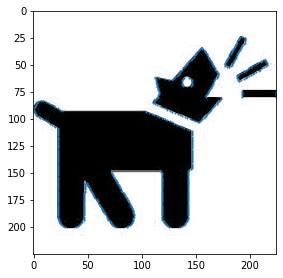

G00 X29 Y24
G01 X39 Y24
G00 X76 Y24
G01 X86 Y24
G00 X125 Y24
G01 X135 Y24
G00 X27 Y25
G01 X41 Y25
G00 X74 Y25
G01 X87 Y25
G00 X124 Y25
G01 X137 Y25
G00 X26 Y26
G01 X42 Y26
G00 X73 Y26
G01 X89 Y26
G00 X123 Y26
G01 X139 Y26
G00 X25 Y27
G01 X43 Y27
G00 X72 Y27
G01 X90 Y27
G00 X122 Y27
G01 X140 Y27
G00 X24 Y28
G01 X44 Y28
G00 X71 Y28
G01 X91 Y28
G00 X121 Y28
G01 X140 Y28
G00 X24 Y29
G01 X45 Y29
G00 X71 Y29
G01 X91 Y29
G00 X120 Y29
G01 X141 Y29
G00 X23 Y30
G01 X45 Y30
G00 X70 Y30
G01 X92 Y30
G00 X120 Y30
G01 X142 Y30
G00 X23 Y31
G01 X46 Y31
G00 X69 Y31
G01 X92 Y31
G00 X119 Y31
G01 X142 Y31
G00 X23 Y32
G01 X46 Y32
G00 X69 Y32
G01 X92 Y32
G00 X119 Y32
G01 X143 Y32
G00 X22 Y33
G01 X46 Y33
G00 X68 Y33
G01 X92 Y33
G00 X119 Y33
G01 X143 Y33
G00 X22 Y34
G01 X46 Y34
G00 X68 Y34
G01 X93 Y34
G00 X119 Y34
G01 X143 Y34
G00 X22 Y35
G01 X46 Y35
G00 X67 Y35
G01 X93 Y35
G00 X119 Y35
G01 X143 Y35
G00 X22 Y36
G01 X46 Y36
G00 X66 Y36
G01 X93 Y36
G00 X119 Y36
G01 X143 Y36
G00 X22 Y37
G01 X46 Y37
G00 X66 Y37
G0

G00 X185 Y190
G01 X192 Y190
G00 X186 Y191
G01 X192 Y191
G00 X186 Y192
G01 X193 Y192
G00 X187 Y193
G01 X193 Y193
G00 X187 Y194
G01 X194 Y194
G00 X188 Y195
G01 X195 Y195
G00 X188 Y196
G01 X195 Y196
G00 X189 Y197
G01 X195 Y197
G00 X190 Y198
G01 X195 Y198
G00 X190 Y199
G01 X195 Y199
G00 X191 Y200
G01 X193 Y200
G00 X29 Y24 ; 
29.0
24.0
G00
----------------------------------------
G01 X39 Y24 ; 
39.0
24.0
G01
----------------------------------------
G00 X76 Y24 ; 
76.0
24.0
G00
----------------------------------------
G01 X86 Y24 ; 
86.0
24.0
G01
----------------------------------------
G00 X125 Y24 ; 
125.0
24.0
G00
----------------------------------------
G01 X135 Y24 ; 
135.0
24.0
G01
----------------------------------------
G00 X27 Y25 ; 
27.0
25.0
G00
----------------------------------------
G01 X41 Y25 ; 
41.0
25.0
G01
----------------------------------------
G00 X74 Y25 ; 
74.0
25.0
G00
----------------------------------------
G01 X87 Y25 ; 
87.0
25.0
G01
-----------------------------

----------------------------------------
G01 X46 Y43 ; 
46.0
43.0
G01
----------------------------------------
G00 X62 Y43 ; 
62.0
43.0
G00
----------------------------------------
G01 X90 Y43 ; 
90.0
43.0
G01
----------------------------------------
G00 X119 Y43 ; 
119.0
43.0
G00
----------------------------------------
G01 X143 Y43 ; 
143.0
43.0
G01
----------------------------------------
G00 X22 Y44 ; 
22.0
44.0
G00
----------------------------------------
G01 X46 Y44 ; 
46.0
44.0
G01
----------------------------------------
G00 X61 Y44 ; 
61.0
44.0
G00
----------------------------------------
G01 X90 Y44 ; 
90.0
44.0
G01
----------------------------------------
G00 X119 Y44 ; 
119.0
44.0
G00
----------------------------------------
G01 X143 Y44 ; 
143.0
44.0
G01
----------------------------------------
G00 X22 Y45 ; 
22.0
45.0
G00
----------------------------------------
G01 X46 Y45 ; 
46.0
45.0
G01
----------------------------------------
G00 X61 Y45 ; 
61.0
45.0
G00
------------

----------------------------------------
G01 X143 Y62 ; 
143.0
62.0
G01
----------------------------------------
G00 X22 Y63 ; 
22.0
63.0
G00
----------------------------------------
G01 X47 Y63 ; 
47.0
63.0
G01
----------------------------------------
G00 X50 Y63 ; 
50.0
63.0
G00
----------------------------------------
G01 X79 Y63 ; 
79.0
63.0
G01
----------------------------------------
G00 X119 Y63 ; 
119.0
63.0
G00
----------------------------------------
G01 X143 Y63 ; 
143.0
63.0
G01
----------------------------------------
G00 X22 Y64 ; 
22.0
64.0
G00
----------------------------------------
G01 X47 Y64 ; 
47.0
64.0
G01
----------------------------------------
G00 X49 Y64 ; 
49.0
64.0
G00
----------------------------------------
G01 X78 Y64 ; 
78.0
64.0
G01
----------------------------------------
G00 X119 Y64 ; 
119.0
64.0
G00
----------------------------------------
G01 X143 Y64 ; 
143.0
64.0
G01
----------------------------------------
G00 X22 Y65 ; 
22.0
65.0
G00
----------

----------------------------------------
G00 X22 Y105 ; 
22.0
105.0
G00
----------------------------------------
G01 X146 Y105 ; 
146.0
105.0
G01
----------------------------------------
G00 X22 Y106 ; 
22.0
106.0
G00
----------------------------------------
G01 X146 Y106 ; 
146.0
106.0
G01
----------------------------------------
G00 X22 Y107 ; 
22.0
107.0
G00
----------------------------------------
G01 X146 Y107 ; 
146.0
107.0
G01
----------------------------------------
G00 X22 Y108 ; 
22.0
108.0
G00
----------------------------------------
G01 X146 Y108 ; 
146.0
108.0
G01
----------------------------------------
G00 X22 Y109 ; 
22.0
109.0
G00
----------------------------------------
G01 X146 Y109 ; 
146.0
109.0
G01
----------------------------------------
G00 X22 Y110 ; 
22.0
110.0
G00
----------------------------------------
G01 X146 Y110 ; 
146.0
110.0
G01
----------------------------------------
G00 X22 Y111 ; 
22.0
111.0
G00
----------------------------------------
G01 X146 Y1

----------------------------------------
G01 X8 Y141 ; 
8.0
141.0
G01
----------------------------------------
G00 X111 Y141 ; 
111.0
141.0
G00
----------------------------------------
G01 X171 Y141 ; 
171.0
141.0
G01
----------------------------------------
G00 X112 Y142 ; 
112.0
142.0
G00
----------------------------------------
G01 X172 Y142 ; 
172.0
142.0
G01
----------------------------------------
G00 X113 Y143 ; 
113.0
143.0
G00
----------------------------------------
G01 X173 Y143 ; 
173.0
143.0
G01
----------------------------------------
G00 X114 Y144 ; 
114.0
144.0
G00
----------------------------------------
G01 X173 Y144 ; 
173.0
144.0
G01
----------------------------------------
G00 X115 Y145 ; 
115.0
145.0
G00
----------------------------------------
G01 X159 Y145 ; 
159.0
145.0
G01
----------------------------------------
G00 X193 Y145 ; 
193.0
145.0
G00
----------------------------------------
G01 X224 Y145 ; 
224.0
145.0
G01
----------------------------------------
G

----------------------------------------
G00 X195 Y169 ; 
195.0
169.0
G00
----------------------------------------
G01 X208 Y169 ; 
208.0
169.0
G01
----------------------------------------
G00 X137 Y170 ; 
137.0
170.0
G00
----------------------------------------
G01 X168 Y170 ; 
168.0
170.0
G01
----------------------------------------
G00 X197 Y170 ; 
197.0
170.0
G00
----------------------------------------
G01 X209 Y170 ; 
209.0
170.0
G01
----------------------------------------
G00 X138 Y171 ; 
138.0
171.0
G00
----------------------------------------
G01 X168 Y171 ; 
168.0
171.0
G01
----------------------------------------
G00 X199 Y171 ; 
199.0
171.0
G00
----------------------------------------
G01 X211 Y171 ; 
211.0
171.0
G01
----------------------------------------
G00 X139 Y172 ; 
139.0
172.0
G00
----------------------------------------
G01 X167 Y172 ; 
167.0
172.0
G01
----------------------------------------
G00 X179 Y172 ; 
179.0
172.0
G00
--------------------------------------

----------------------------------------
G00 X190 Y199 ; 
190.0
199.0
G00
----------------------------------------
G01 X195 Y199 ; 
195.0
199.0
G01
----------------------------------------
G00 X191 Y200 ; 
191.0
200.0
G00
----------------------------------------
G01 X193 Y200 ; 
193.0
200.0
G01
----------------------------------------
G00 X29 Y24 ; 
29.0
24.0
G00
----------------------------------------
G01 X39 Y24 ; 
39.0
24.0
G01
----------------------------------------
G00 X76 Y24 ; 
76.0
24.0
G00
----------------------------------------
G01 X86 Y24 ; 
86.0
24.0
G01
----------------------------------------
G00 X125 Y24 ; 
125.0
24.0
G00
----------------------------------------
G01 X135 Y24 ; 
135.0
24.0
G01
----------------------------------------
G00 X27 Y25 ; 
27.0
25.0
G00
----------------------------------------
G01 X41 Y25 ; 
41.0
25.0
G01
----------------------------------------
G00 X74 Y25 ; 
74.0
25.0
G00
----------------------------------------
G01 X87 Y25 ; 
87.0
25.0
G01


----------------------------------------
G01 X46 Y43 ; 
46.0
43.0
G01
----------------------------------------
G00 X62 Y43 ; 
62.0
43.0
G00
----------------------------------------
G01 X90 Y43 ; 
90.0
43.0
G01
----------------------------------------
G00 X119 Y43 ; 
119.0
43.0
G00
----------------------------------------
G01 X143 Y43 ; 
143.0
43.0
G01
----------------------------------------
G00 X22 Y44 ; 
22.0
44.0
G00
----------------------------------------
G01 X46 Y44 ; 
46.0
44.0
G01
----------------------------------------
G00 X61 Y44 ; 
61.0
44.0
G00
----------------------------------------
G01 X90 Y44 ; 
90.0
44.0
G01
----------------------------------------
G00 X119 Y44 ; 
119.0
44.0
G00
----------------------------------------
G01 X143 Y44 ; 
143.0
44.0
G01
----------------------------------------
G00 X22 Y45 ; 
22.0
45.0
G00
----------------------------------------
G01 X46 Y45 ; 
46.0
45.0
G01
----------------------------------------
G00 X61 Y45 ; 
61.0
45.0
G00
------------

----------------------------------------
G01 X79 Y62 ; 
79.0
62.0
G01
----------------------------------------
G00 X119 Y62 ; 
119.0
62.0
G00
----------------------------------------
G01 X143 Y62 ; 
143.0
62.0
G01
----------------------------------------
G00 X22 Y63 ; 
22.0
63.0
G00
----------------------------------------
G01 X47 Y63 ; 
47.0
63.0
G01
----------------------------------------
G00 X50 Y63 ; 
50.0
63.0
G00
----------------------------------------
G01 X79 Y63 ; 
79.0
63.0
G01
----------------------------------------
G00 X119 Y63 ; 
119.0
63.0
G00
----------------------------------------
G01 X143 Y63 ; 
143.0
63.0
G01
----------------------------------------
G00 X22 Y64 ; 
22.0
64.0
G00
----------------------------------------
G01 X47 Y64 ; 
47.0
64.0
G01
----------------------------------------
G00 X49 Y64 ; 
49.0
64.0
G00
----------------------------------------
G01 X78 Y64 ; 
78.0
64.0
G01
----------------------------------------
G00 X119 Y64 ; 
119.0
64.0
G00
----------

----------------------------------------
G01 X146 Y105 ; 
146.0
105.0
G01
----------------------------------------
G00 X22 Y106 ; 
22.0
106.0
G00
----------------------------------------
G01 X146 Y106 ; 
146.0
106.0
G01
----------------------------------------
G00 X22 Y107 ; 
22.0
107.0
G00
----------------------------------------
G01 X146 Y107 ; 
146.0
107.0
G01
----------------------------------------
G00 X22 Y108 ; 
22.0
108.0
G00
----------------------------------------
G01 X146 Y108 ; 
146.0
108.0
G01
----------------------------------------
G00 X22 Y109 ; 
22.0
109.0
G00
----------------------------------------
G01 X146 Y109 ; 
146.0
109.0
G01
----------------------------------------
G00 X22 Y110 ; 
22.0
110.0
G00
----------------------------------------
G01 X146 Y110 ; 
146.0
110.0
G01
----------------------------------------
G00 X22 Y111 ; 
22.0
111.0
G00
----------------------------------------
G01 X146 Y111 ; 
146.0
111.0
G01
----------------------------------------
G00 X22 Y

----------------------------------------
G00 X111 Y141 ; 
111.0
141.0
G00
----------------------------------------
G01 X171 Y141 ; 
171.0
141.0
G01
----------------------------------------
G00 X112 Y142 ; 
112.0
142.0
G00
----------------------------------------
G01 X172 Y142 ; 
172.0
142.0
G01
----------------------------------------
G00 X113 Y143 ; 
113.0
143.0
G00
----------------------------------------
G01 X173 Y143 ; 
173.0
143.0
G01
----------------------------------------
G00 X114 Y144 ; 
114.0
144.0
G00
----------------------------------------
G01 X173 Y144 ; 
173.0
144.0
G01
----------------------------------------
G00 X115 Y145 ; 
115.0
145.0
G00
----------------------------------------
G01 X159 Y145 ; 
159.0
145.0
G01
----------------------------------------
G00 X193 Y145 ; 
193.0
145.0
G00
----------------------------------------
G01 X224 Y145 ; 
224.0
145.0
G01
----------------------------------------
G00 X115 Y146 ; 
115.0
146.0
G00
--------------------------------------

----------------------------------------
G00 X197 Y170 ; 
197.0
170.0
G00
----------------------------------------
G01 X209 Y170 ; 
209.0
170.0
G01
----------------------------------------
G00 X138 Y171 ; 
138.0
171.0
G00
----------------------------------------
G01 X168 Y171 ; 
168.0
171.0
G01
----------------------------------------
G00 X199 Y171 ; 
199.0
171.0
G00
----------------------------------------
G01 X211 Y171 ; 
211.0
171.0
G01
----------------------------------------
G00 X139 Y172 ; 
139.0
172.0
G00
----------------------------------------
G01 X167 Y172 ; 
167.0
172.0
G01
----------------------------------------
G00 X179 Y172 ; 
179.0
172.0
G00
----------------------------------------
G01 X181 Y172 ; 
181.0
172.0
G01
----------------------------------------
G00 X201 Y172 ; 
201.0
172.0
G00
----------------------------------------
G01 X213 Y172 ; 
213.0
172.0
G01
----------------------------------------
G00 X140 Y173 ; 
140.0
173.0
G00
--------------------------------------

In [ ]:
mainFrame = MainWindow(None, "2D Plotter")
mainFrame.CenterOnScreen()
mainFrame.SetFocus()
mainFrame.Raise()
app.MainLoop()